## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

## Inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("savedOutputs/xvalO.npy")
yvalO = np.load("savedOutputs/yvalO.npy")
xerrO = np.load("savedOutputs/xerrO.npy")
xlowO = list(np.load("savedOutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("savedOutputs/xval.npy")
yval = np.load("savedOutputs/yval.npy")
xerr = np.load("savedOutputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("savedOutputs/toyList.npy")
fixedHyperparams = np.load("savedOutputs/fixedHyperparams.npy")

#injected gaussian signals 
sigToys = np.load("savedOutputs/signalToys.npy")
sigToysO = np.load("savedOutputs/signalToysO.npy")
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]

### Calculate z values and chi squared 

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2


### poisson likelihood

In [5]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits. Add back in zero bins for final prediction

In [6]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xvalO):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                continue
            else:
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

## signal+background and background only plotted together

In [30]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 3e5):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="Toy data plus injected signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="Gaussian Process background")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='b', linewidth=3.0, label="Gaussian Process background plus signal")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=25)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=25)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+signal vs bkg",(2520,-3.5), fontsize=25)

    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=25)
    ax3.tick_params(axis='x', labelsize=25)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+signal vs bkg+signal",(2520,-3.5), fontsize=25)
    

    zvals_3, chi2_3 = calcSignificance(ys_b, bkgs)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=25)
    ax4.tick_params(axis='x', labelsize=25)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(2520,-3.5), fontsize=25)
    
    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    


### signal only component of signal+background fit

In [35]:
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="Toy data plus injected signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="Gaussian Process signal")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=35)
    ax2.tick_params(axis='y', labelsize=35)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    ax2.set_ylabel('Significance', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Mean function for GP

In [9]:
def model_gp(params, t, xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

### Fit signal GP hyperparameters by minimizing george likelihood with minuit. Keep hyperparameters for background GP fixed

In [10]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Basic plot of data

In [11]:
def basicPlot(xs, ys, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(10,10))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10)
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_ylim([0.01, 2e6])
    
    ax1.set_xscale('log')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)

### piecewise linear function for signal

In [12]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)
        if c > center and c < center+width:
            output[i]=(-slope*c+slope*center+amp)
    output = [s if s > 0 else 0 for s in output]
    return output

### square signal function

In [13]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp
    return output

### Gaussian signal function

In [14]:
def gaus(x, amp, center, width, xerr):
    return amp*(np.exp(-(x-center)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xerr

### Smearing functions - use Gaussian kernel to smooth out signals

In [15]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smearO(s, signal_shape):
    smeared_counts=np.zeros(len(xvalO))
    for xi, x in enumerate(xvalO):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [16]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape):
    smeared_counts=np.zeros(len(xval))
    for xi, x in enumerate(xval):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

### Fit GP, break about into signal and background components

In [17]:
def makeGP(ycounts, xxs, xxserr):
    Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp 
    lnProb = logLike_gp_fitgpsig(xxs, ycounts, xxserr)
    bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, True)
    if np.isinf(bestval): 
        print "failed"
        return np.inf, np.inf, np.inf, np.inf
        
    A, mass, tau = best_fit_new 
    print "A, mas, tau", A, mass, tau
    
    kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
    kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

    
    kernel = kernel1 + kernel2
    gp = george.GP(kernel)
    gp.compute(xxs, np.sqrt(ycounts))
    meanGPp = gp.predict( ycounts - model_gp((p0,p1,p2),xxs, xxserr), xxs)[0]
    meanGP = meanGPp + model_gp((p0,p1,p2),xxs,xxserr)

    gp2 = george.GP(kernel)
    gp2.compute(xxs, np.sqrt(ycounts))
    K1 = kernel1.get_value(np.atleast_2d(xxs).T)
    mu1 = np.dot(K1, gp2.solver.apply_inverse(ycounts- model_gp((p0,p1,p2),xxs, xxserr))) + model_gp((p0,p1, p2),xxs,  xxserr)
    K2 = kernel2.get_value(np.atleast_2d(xxs).T)
    mu2 = np.dot(K2, gp2.solver.apply_inverse(ycounts- model_gp((p0,p1,p2),xxs, xxserr)))

    
    return meanGP, mu1, mu2, (A, mass, tau)

### Minimize george likelihood to fit background hyperparameters

In [18]:
class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

def fit_gp_minuit(lnprob, Print = True):
    passedFit = False
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0, 0, 0, 0, 0)
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1., error_decay = 0.1, error_length = 0.1, error_power = 0.1, 
                   error_sub = 0.1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (100., 1e15), limit_decay = (0, 500), limit_length = (0, 300), 
                   limit_power = (-200, 200), limit_sub = (0, 1000), limit_p0 = (0,10), 
                   limit_p1 = (-20, 20), limit_p2 = (-20,0)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
        
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params



### Gaussian signals

parameters (1500, 2000, 300)
(1.1085729233377313, 1000.0000000003034, 100.0000000000002)
(1.0019352107516433, 1000.6000408756141, 100.016779325295)
(2981.03200099148, 2191.639295955035, 140.8238163086434)
(2983.1118045684866, 2191.34489893509, 140.81555300830453)
(2989.5808542694253, 2191.4771120839023, 140.72411559326815)
(2990.144340575092, 2191.4128952330966, 140.77003115616762)
(2991.2086907215494, 2191.5226200093953, 140.75953742682367)
A, mass, tau 2991.20869072 2191.52262001 140.759537427


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 63.5849506454
chi2 bkg+signal nan


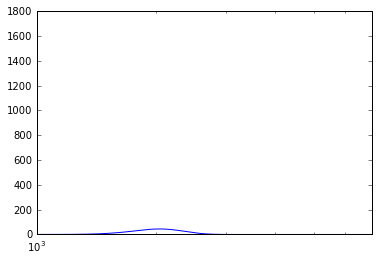

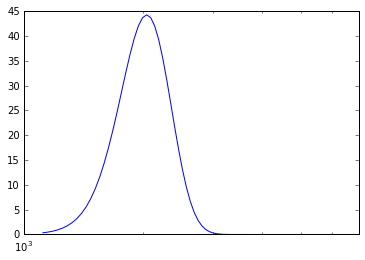

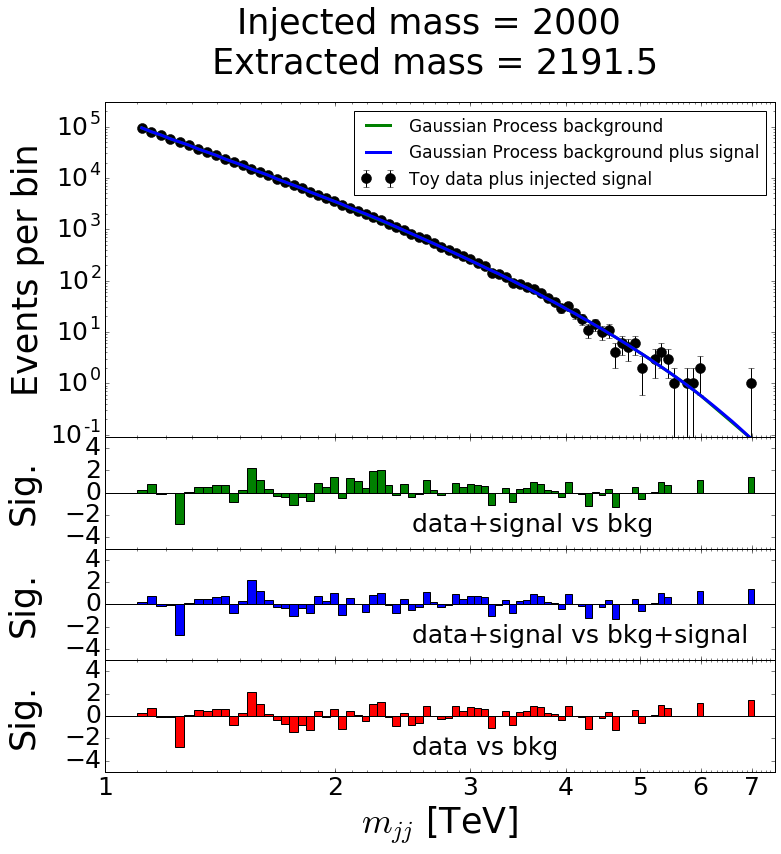

chi2 93110102239.6


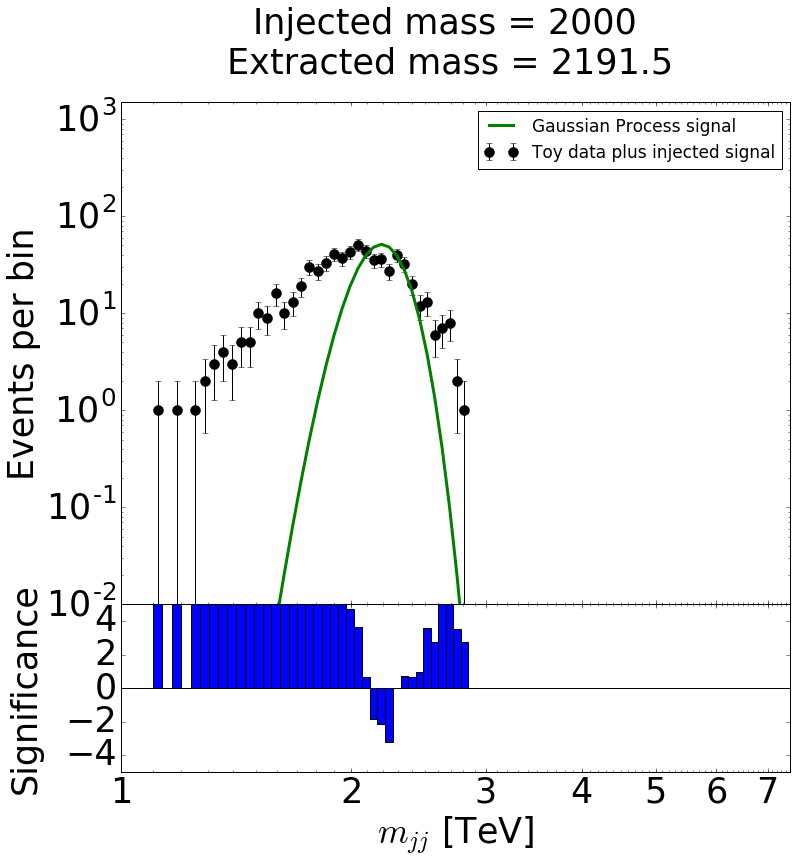

parameters (800, 2500, 250)
(1010.2121050951602, 2574.6867723461546, 297.90699122063194)
(1011.5379879694684, 2574.7814139208726, 297.54101819324353)
(1010.937359453101, 2574.874723186086, 297.69275822851023)
(1017.320541306692, 2574.719793964008, 297.6021500995024)
(1013.2850384216197, 2574.921151387083, 297.55768538823816)
(1013.1847519967483, 2574.9215060865395, 297.62564218402576)
(1014.9671715815666, 2574.8120501489693, 297.6627261365537)
(1013.9167375299567, 2574.860426184915, 297.6164384176516)
A, mass, tau 1013.91673753 2574.86042618 297.616438418
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.1072995793
chi2 bkg+signal nan


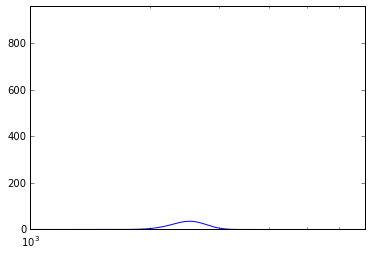

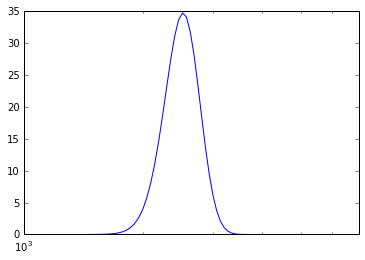

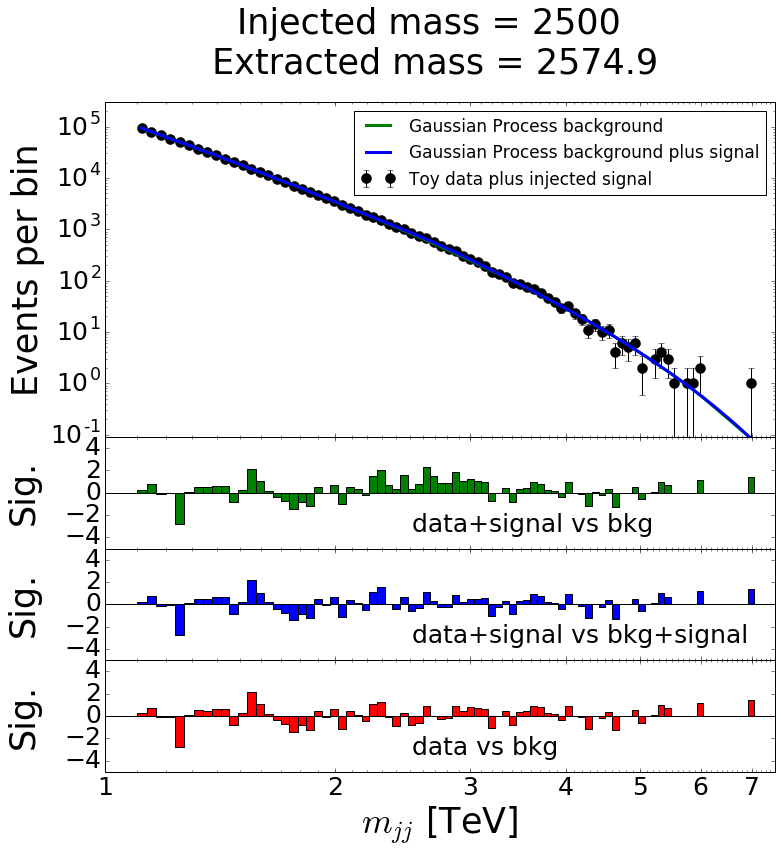

chi2 36.7704874706


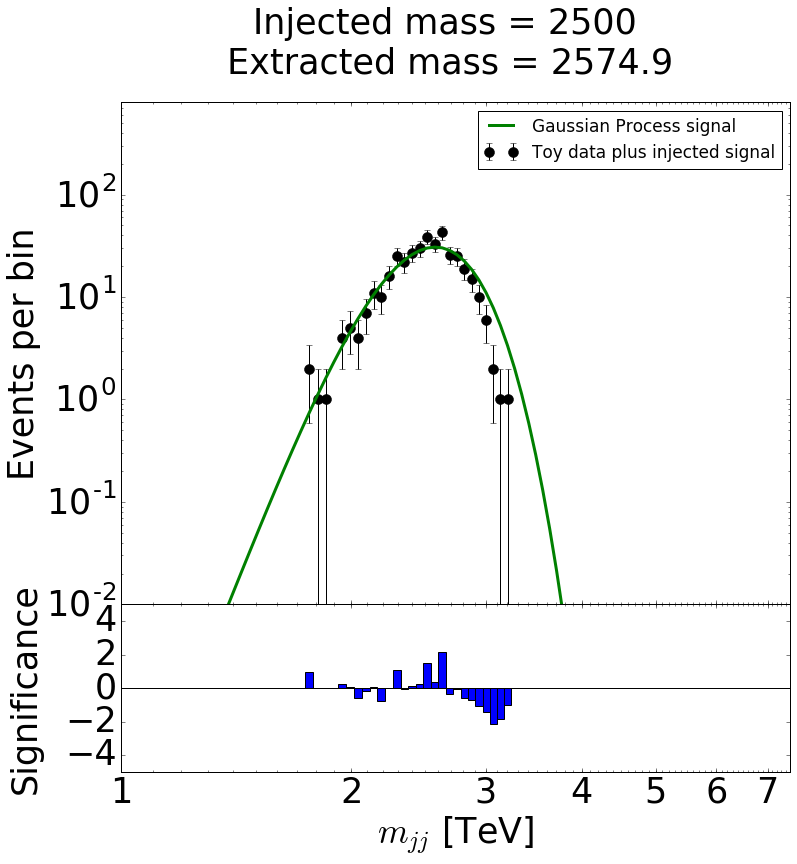

parameters (500, 3000, 250)
(1118.0897756676463, 2988.548426522242, 233.95330563469315)
(1115.5780749669937, 2988.9147634041233, 233.9370914515027)
A, mass, tau 1115.57807497 2988.9147634 233.937091452
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.079230954
chi2 bkg+signal nan


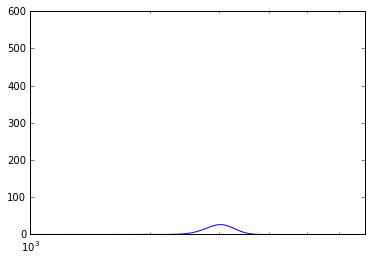

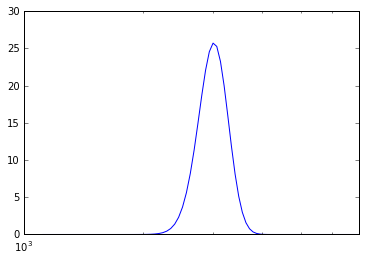

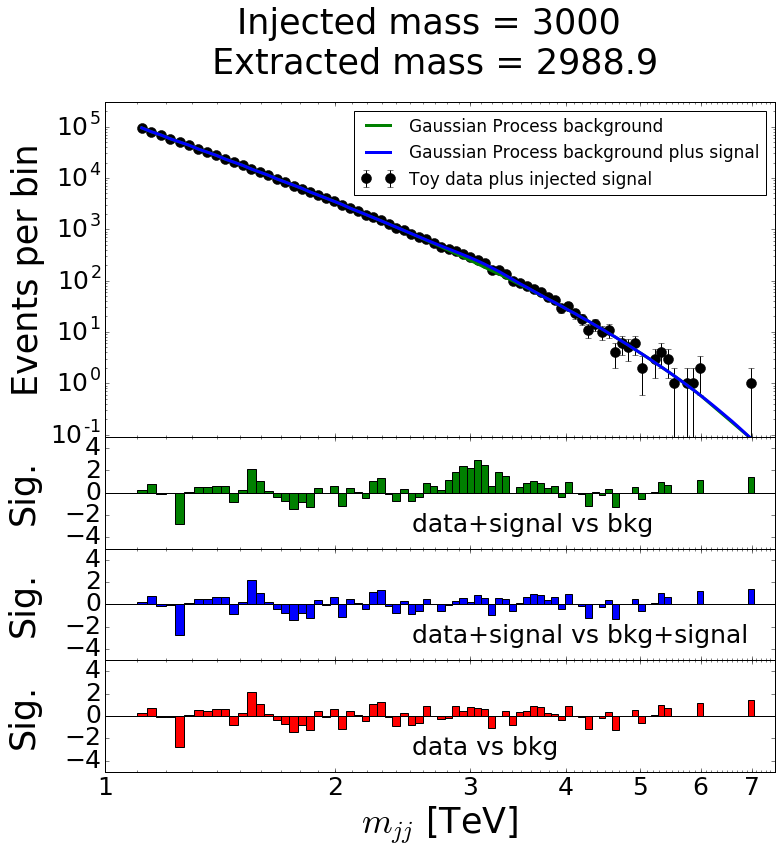

chi2 43.9358320103


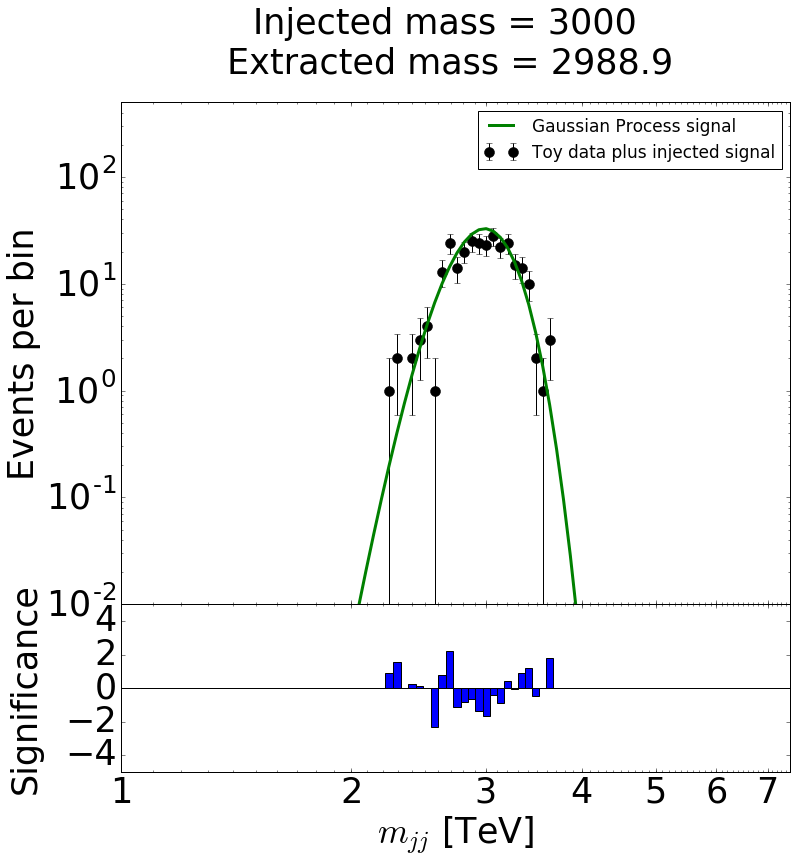

parameters (300, 3500, 250)
(3213.193639568702, 1779.309044432495, 100.00000081288228)
(546.9440625319357, 3523.6692337570466, 238.00443088203465)
A, mass, tau 546.944062532 3523.66923376 238.004430882
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 66.8087057587
chi2 bkg+signal nan


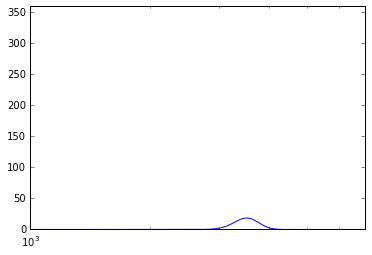

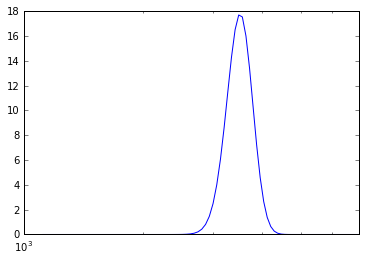

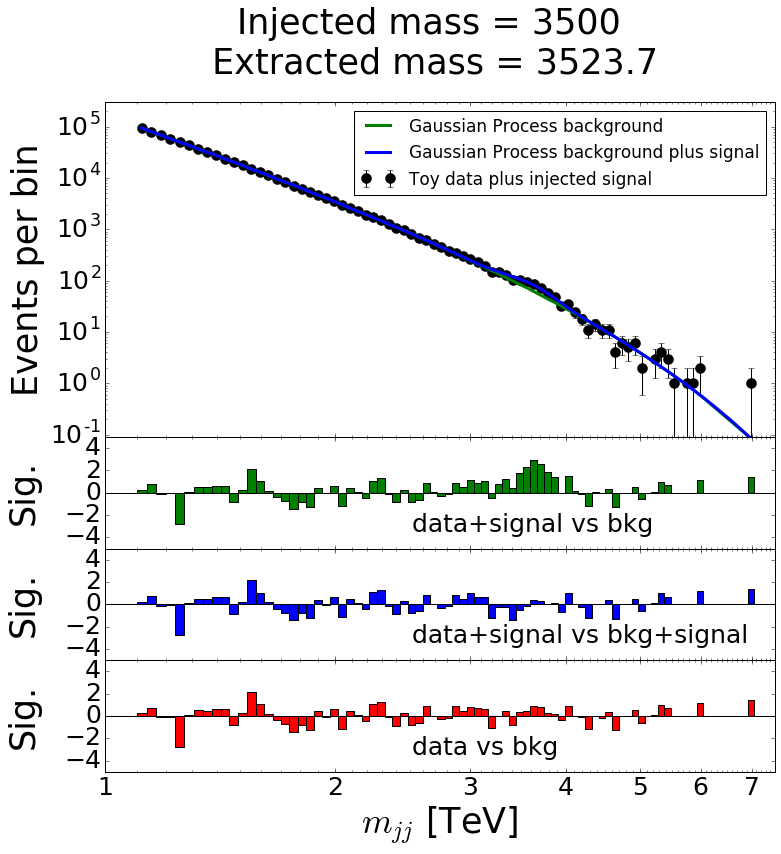

chi2 18.5465881208


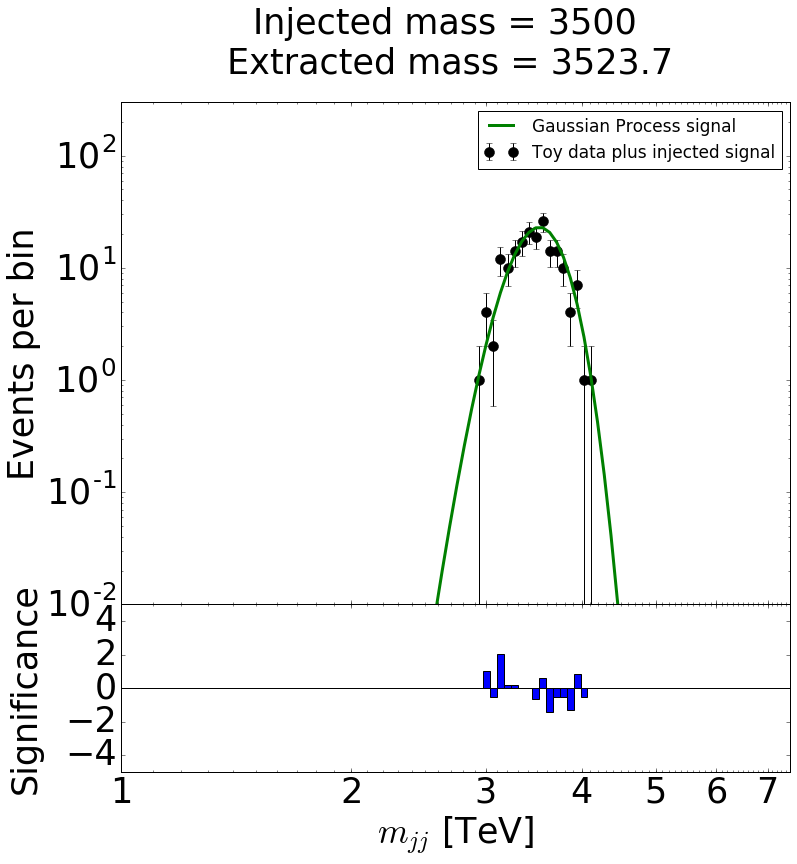

parameters (100, 4000, 250)
(80.26650241761172, 2975.026401359421, 100.00256942218098)
(3237.6907629627226, 1779.2111687794286, 100.0)
(3224.753841451931, 1779.342155400238, 100.00000004314668)
(72.84769285587858, 3865.589562842721, 257.0338646000087)
(72.90525881867708, 3865.6969967694768, 256.83751010344076)
A, mass, tau 72.9052588187 3865.69699677 256.837510103
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 67.7304912212
chi2 bkg+signal nan


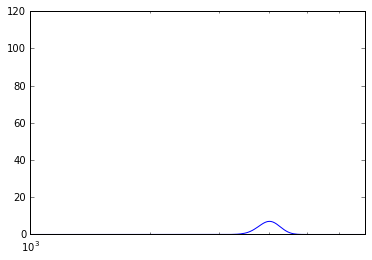

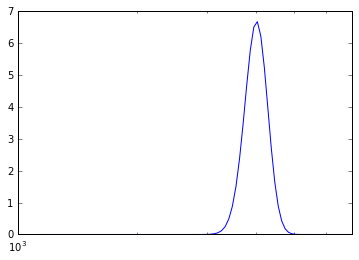

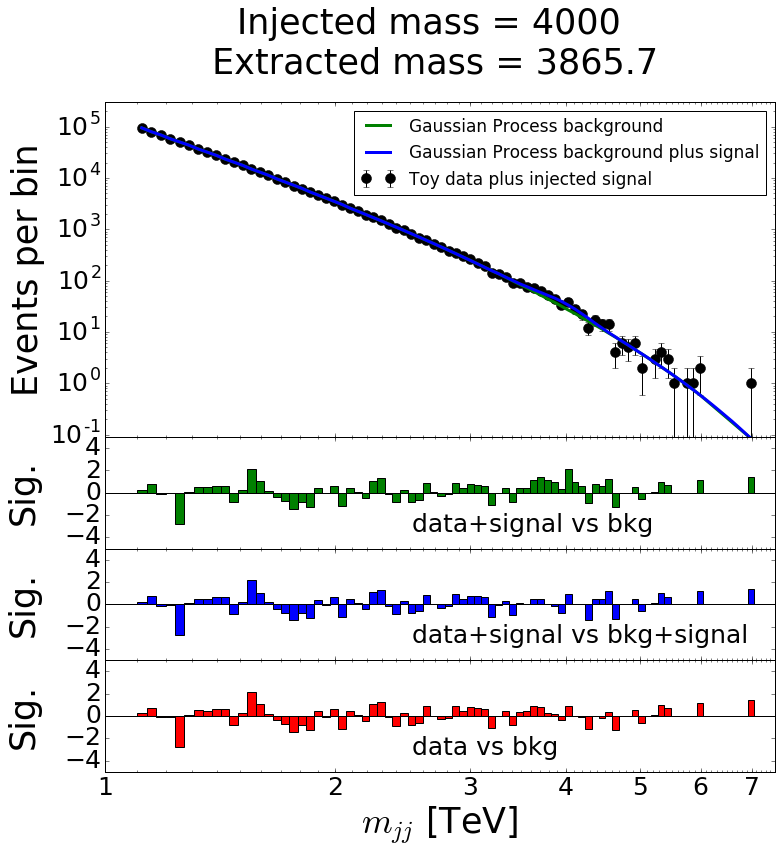

chi2 111.430217302


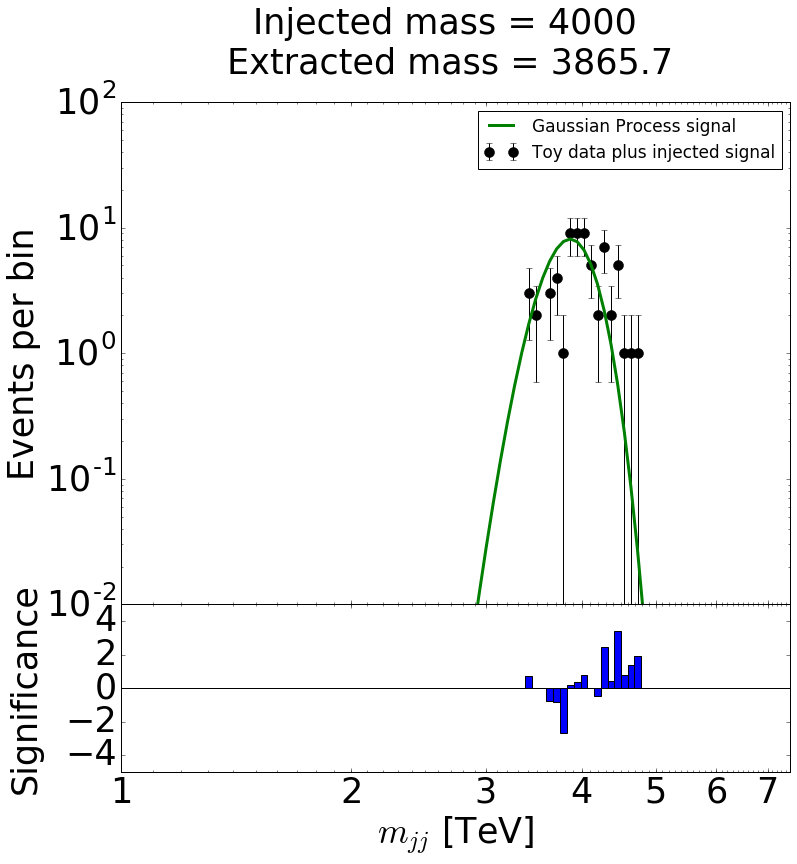

parameters (75, 4500, 250)
(3257.063241858716, 1779.456325308763, 100.0)
(3237.7965756735043, 1779.2807814943194, 100.00003016466698)
(3241.1245895053494, 1779.3496191685454, 100.00000711499044)
(3238.8111699093765, 1779.3244500294677, 100.00000029078235)
A, mass, tau 3238.81116991 1779.32445003 100.000000291
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 88.4215748322
chi2 bkg+signal nan


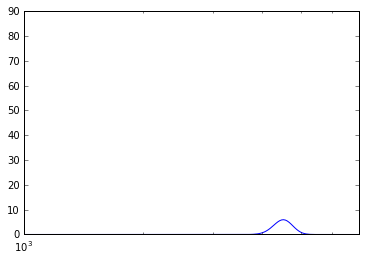

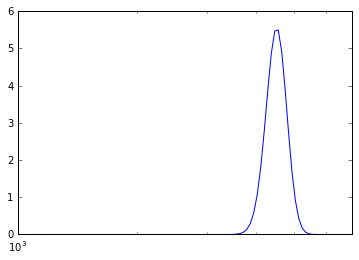

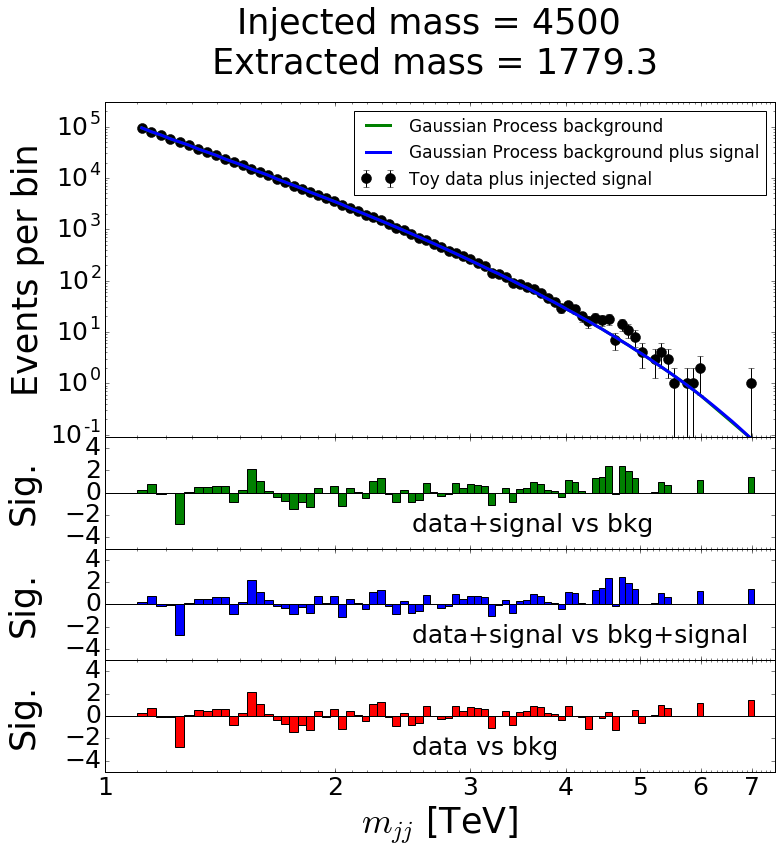

chi2 nan


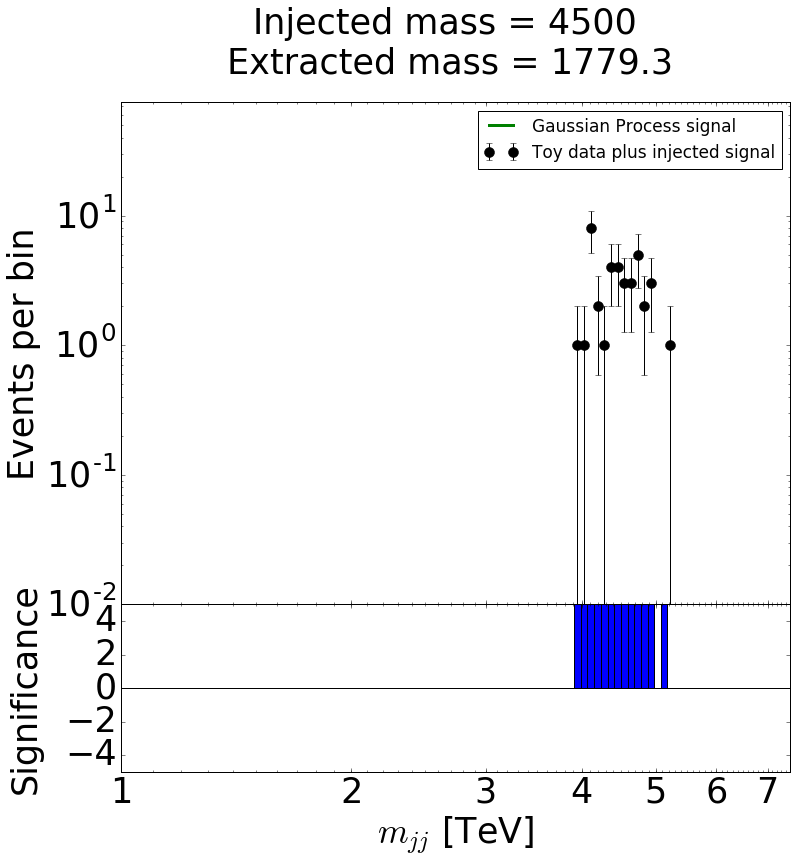

parameters (50, 5000, 250)
(1.000038154386686, 2168.650951164702, 106.6200282984472)
(1.1985216641552747, 1192.1476832327994, 100.0000061749803)
(1.0007523443628272, 1000.0000000003057, 100.00000000000017)
(3243.8753689902314, 1778.9011679308785, 100.0004649639211)
(3232.286786026591, 1779.3622187811457, 100.00002323376911)
(3234.987912575114, 1779.318614628026, 100.00000040450377)
(3235.019008997718, 1779.3410287262438, 100.00000000333318)
A, mass, tau 3235.019009 1779.34102873 100.000000003


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 78.8562322333
chi2 bkg+signal nan


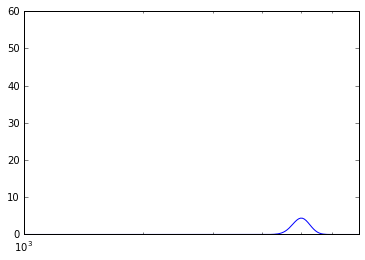

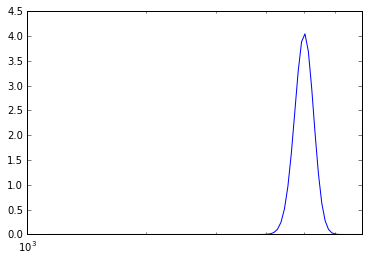

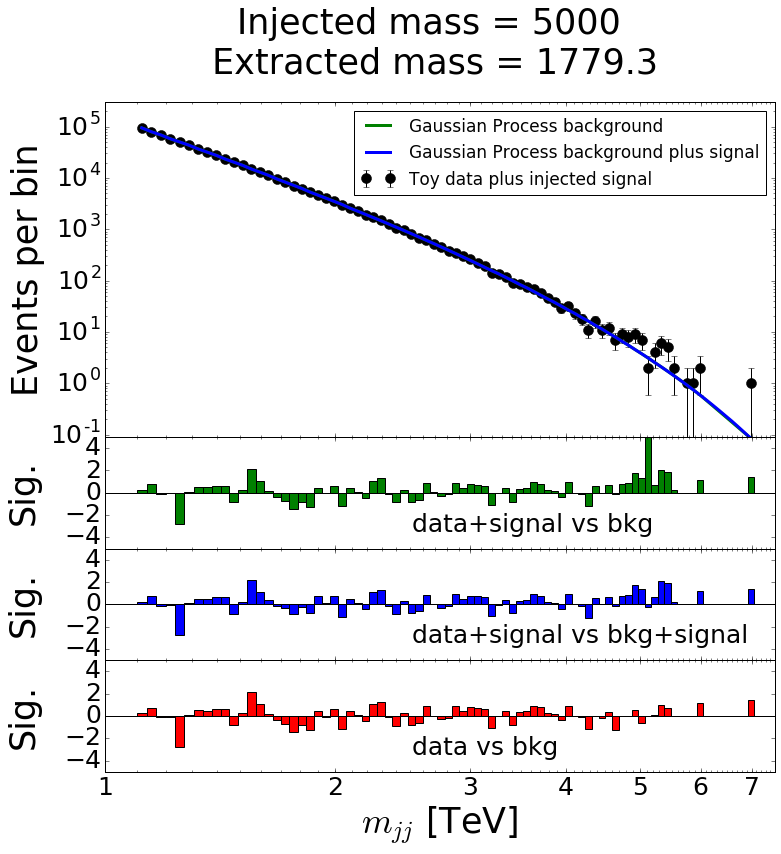

chi2 nan


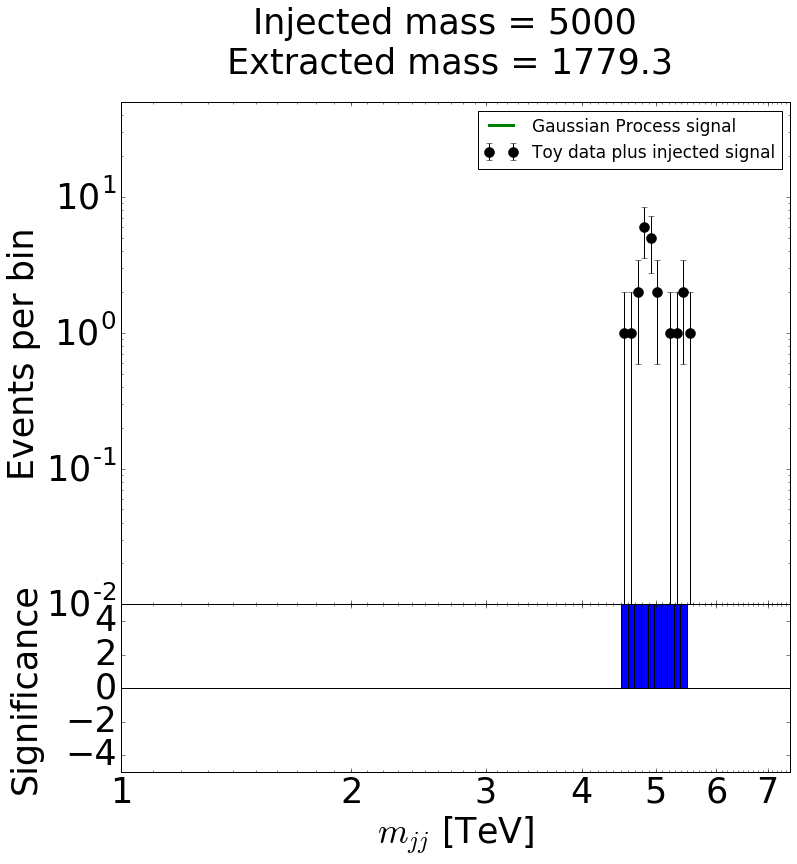

parameters (25, 5500, 250)
(3670.6732591238483, 1510.4197340212027, 100.0000000804345)
(3186.071319095256, 1779.2948599708304, 100.00000050047262)
(3224.7928323487004, 1779.3718916776977, 100.00002039003732)
(3230.963852143515, 1779.2764863589425, 100.00000014915989)
(3233.024901407536, 1779.3250765101905, 100.0000046194272)
(12.771601077834863, 5567.227562793555, 232.10619718926253)
A, mass, tau 12.7716010778 5567.22756279 232.106197189
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.1124472328
chi2 bkg+signal nan


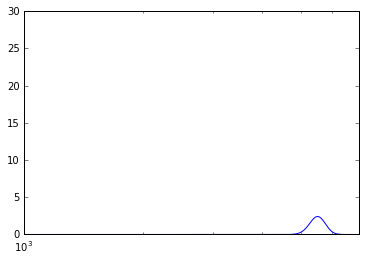

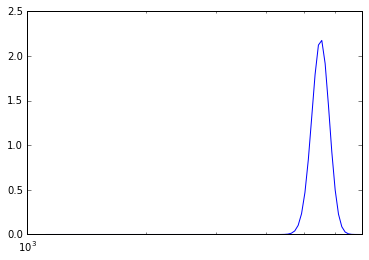

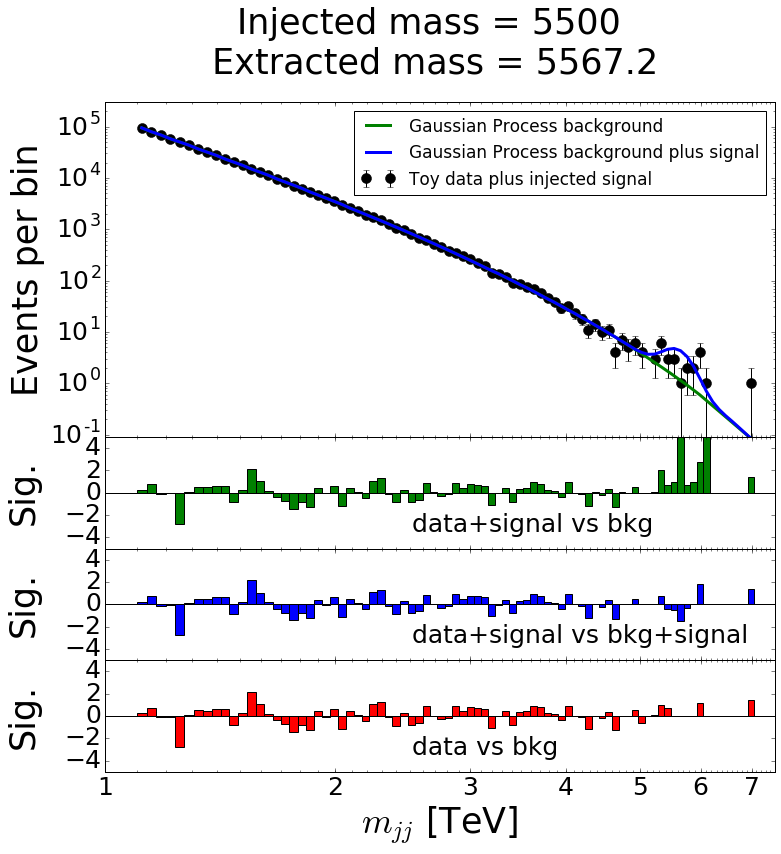

chi2 16.3441000617


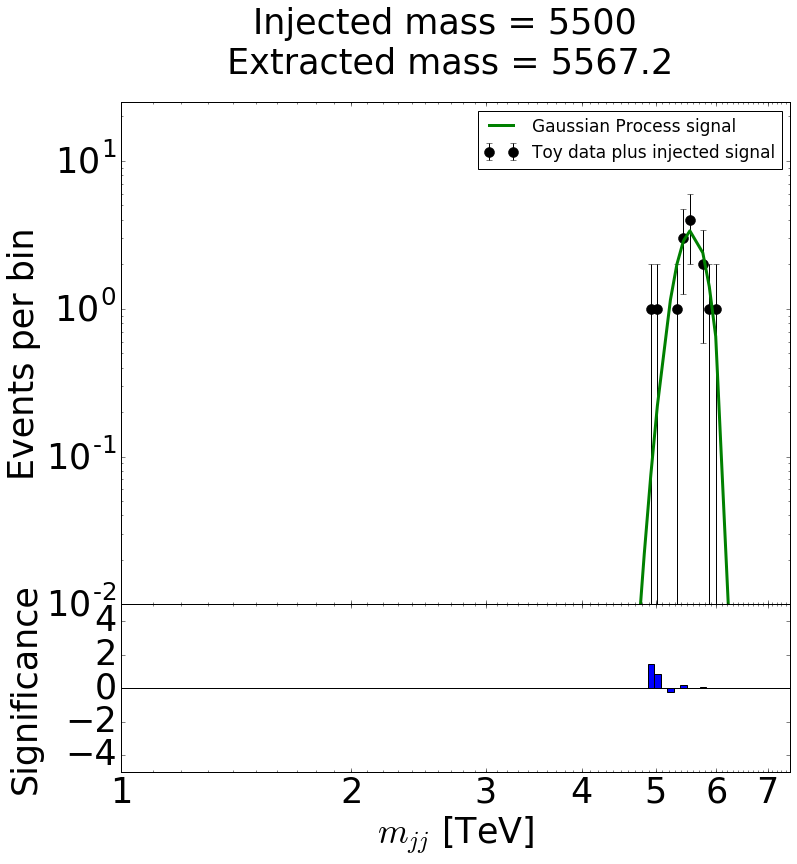

parameters (15, 6000, 250)
(78.88805618970966, 2974.3949368512704, 100.00005158761216)
(80.53182039825192, 2974.816000924922, 100.00000453466696)
(3672.5301394940484, 1510.7191079574677, 100.0000003012049)
(3237.471981965419, 1779.2647004673759, 100.00000408349533)
(3235.082423851907, 1779.321406083052, 100.00000001548088)
(3234.64729442654, 1779.3372597643647, 100.00000000009341)
(75.61445973917859, 6079.426910942285, 102.3293371502507)
A, mass, tau 75.6144597392 6079.42691094 102.32933715
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 78.1353753181
chi2 bkg+signal nan


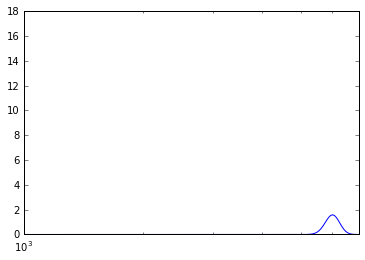

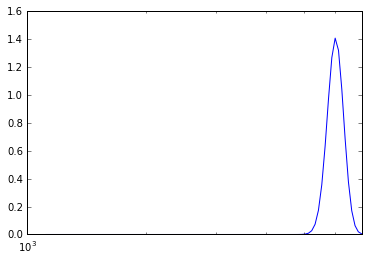

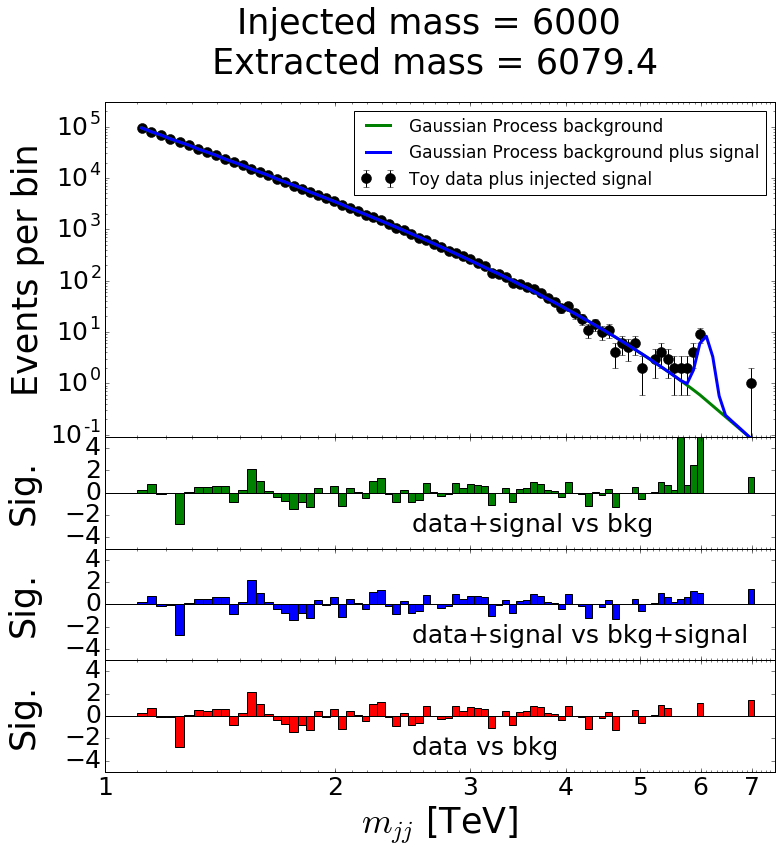

chi2 nan


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


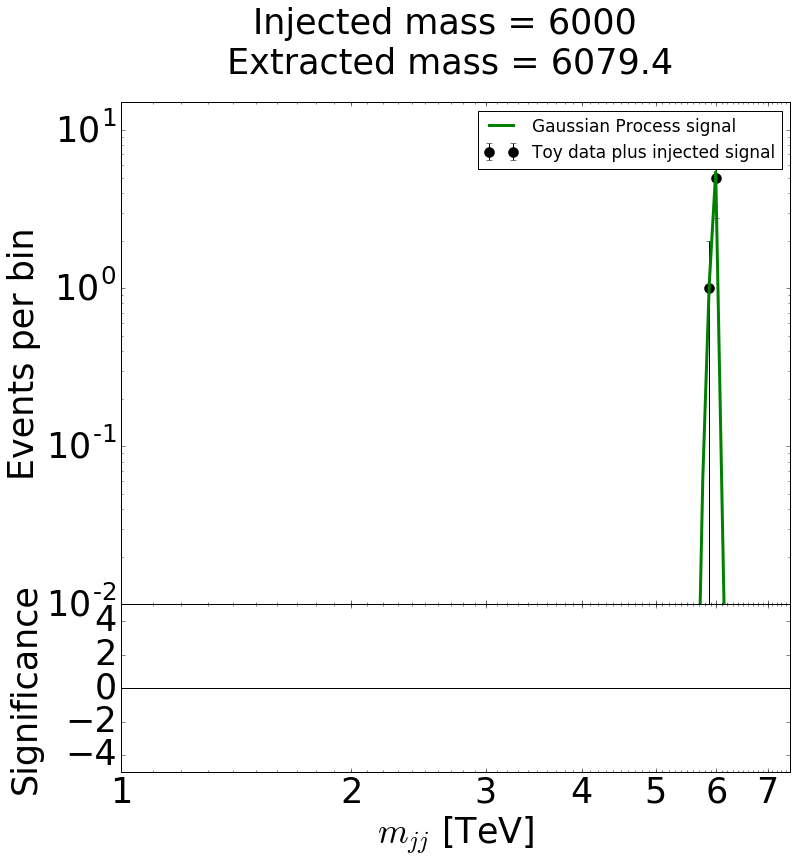

In [36]:
aa={}
mm={}
ww={}
standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        

In [23]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

parameters (1500, 2000, 250)
15067.0643645 2036.92513952 242.884387149
parameters (750, 2500, 250)
5074.67093663 2516.29421701 257.851477881
parameters (200, 3000, 250)
709.448613717 3210.98923313 225.746718275
parameters (75, 3500, 250)
726.029940549 3562.88758486 191.053994807
parameters (50, 4000, 250)
1944.14443984 3868.12108777 183.744751774
parameters (25, 4500, 250)
3422.21628296 3719.65437962 150.635175257
parameters (20, 5000, 250)
4551.46933484 3785.34237168 164.28300932
parameters (15, 5500, 250)
1090.14827872 4336.76433285 194.476684844
parameters (15, 6000, 250)
1892.18368669 4374.46668927 202.411164576


### Peak signals

parameters (200, 2000, 300)
(29270.928260844063, 2040.7466682593565, 150.18869809834962)
(29324.759660781845, 2040.7915147140636, 150.1287065539796)
(29361.032313031123, 2040.7817543095914, 150.1260371369052)
(29354.88231862961, 2040.761145287236, 150.11103590420555)
(29379.730193849224, 2040.7559216065806, 150.1154818652385)
(29382.29431233054, 2040.7503803105933, 150.12306103292926)
A, mass, tau 29382.2943123 2040.75038031 150.123061033


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.2358400236
chi2 bkg+signal nan


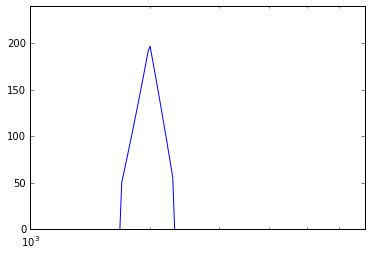

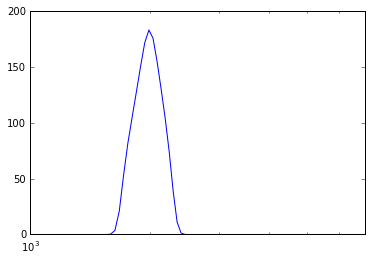

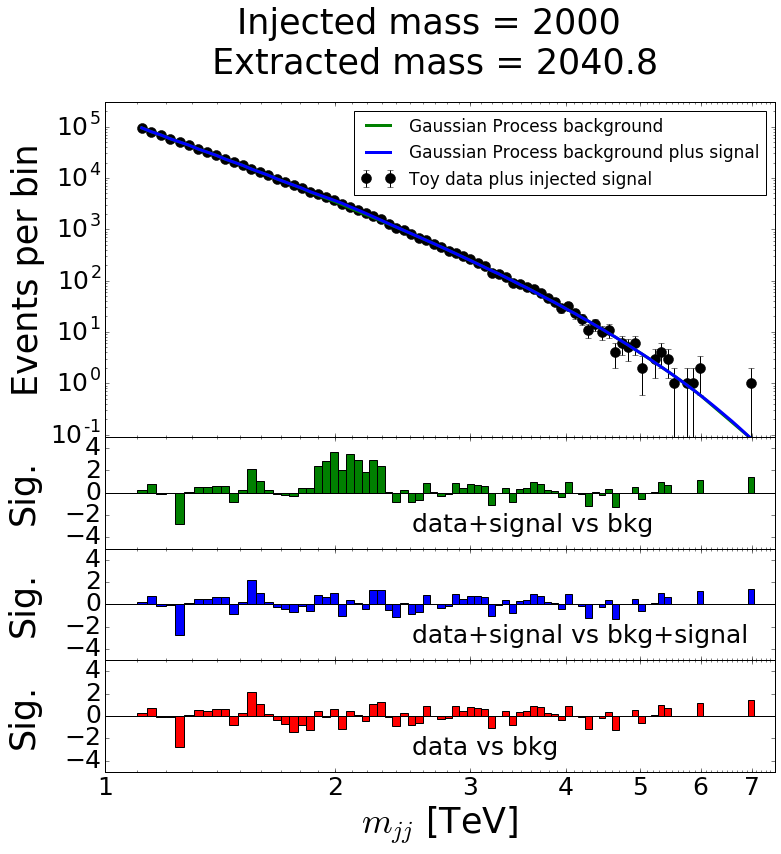

chi2 326.56603636


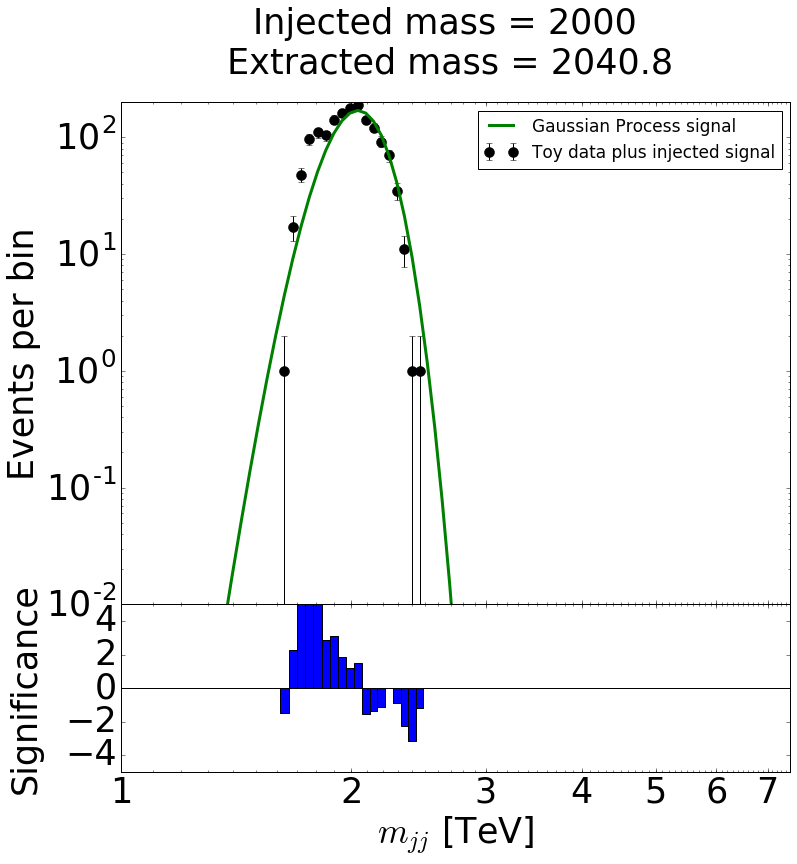

parameters (100, 2500, 250)
(1.0022673002062168, 1013.4851143776627, 100.0661996142922)
(3396.3547139940047, 2479.315269850215, 137.63308332288494)
(3398.4618730318816, 2479.314189218815, 137.6538061887493)
A, mass, tau 3398.46187303 2479.31418922 137.653806189
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.0493559358
chi2 bkg+signal nan


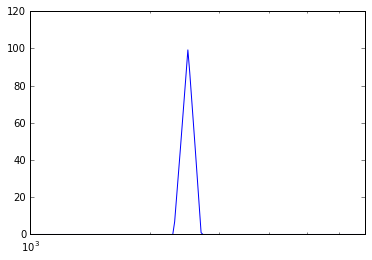

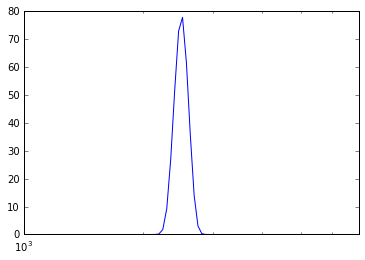

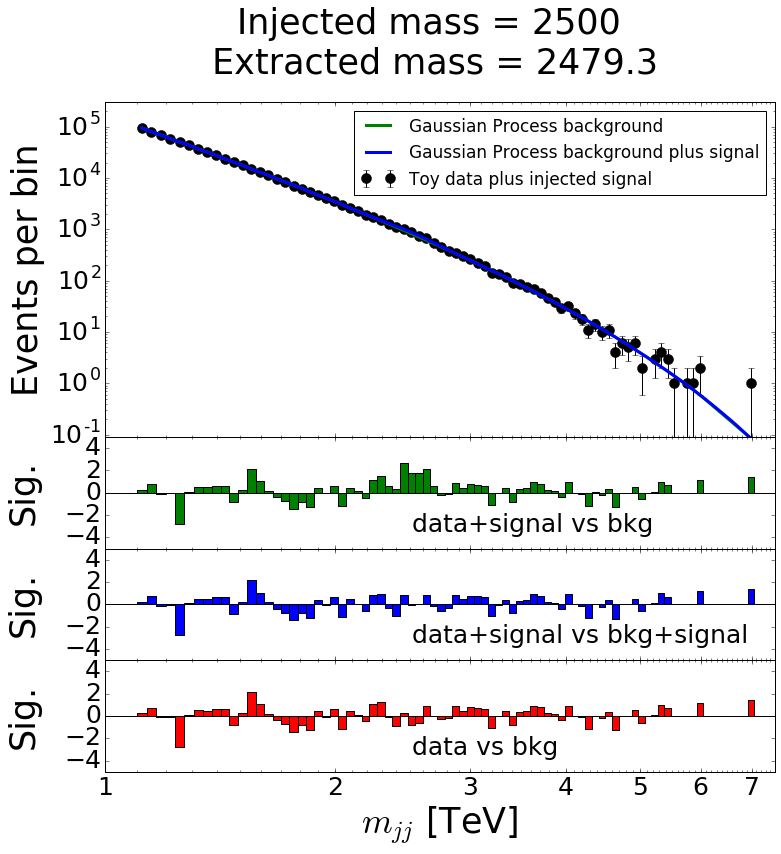

chi2 68.0166799006


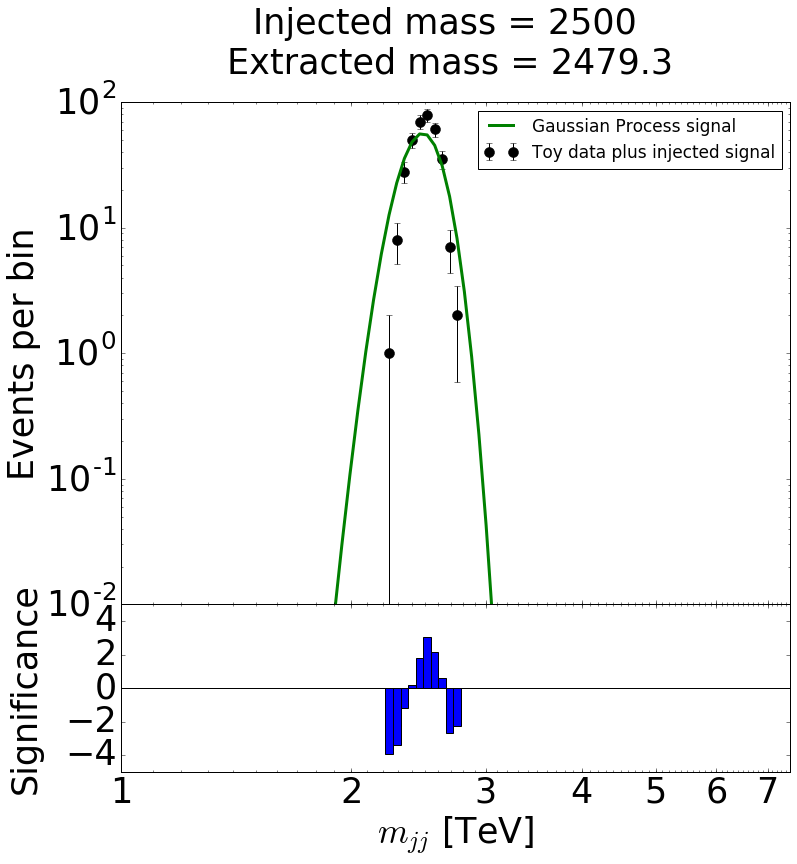

parameters (75, 3000, 250)
(1.0872967289767876, 1202.689543652943, 100.00000178445887)
(3672.985101517837, 1510.4315480723676, 100.00000150552535)
(3228.3406658419476, 1779.2020651296407, 100.00164957054356)
(2868.5903907794977, 2980.8040858955737, 100.00000000008922)
A, mass, tau 2868.59039078 2980.8040859 100.0
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.3337591227
chi2 bkg+signal nan


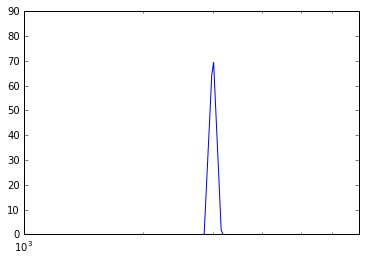

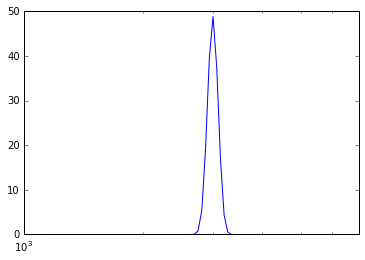

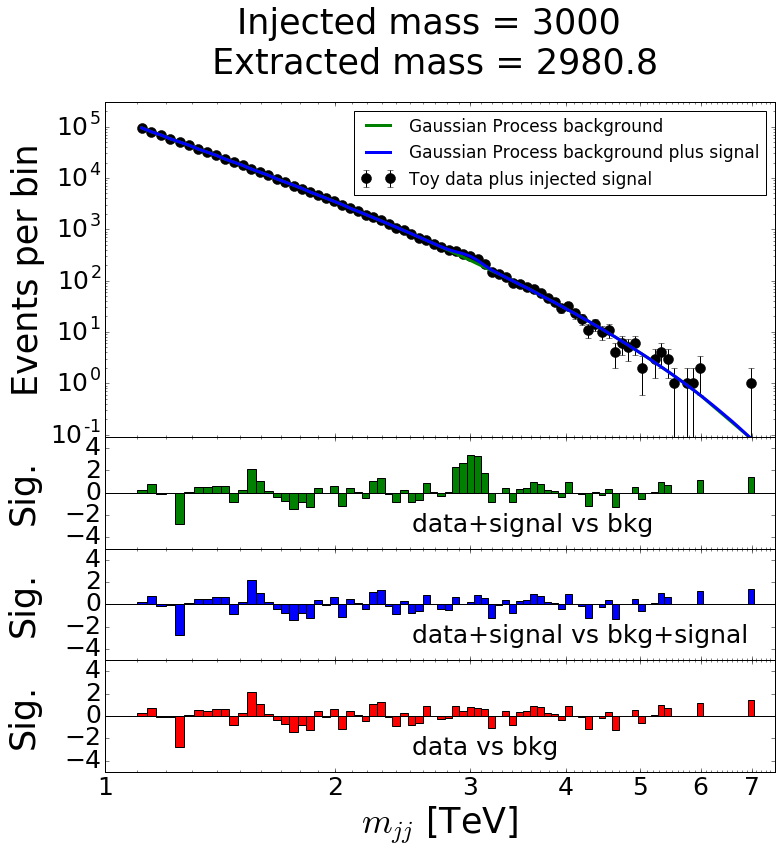

chi2 nan


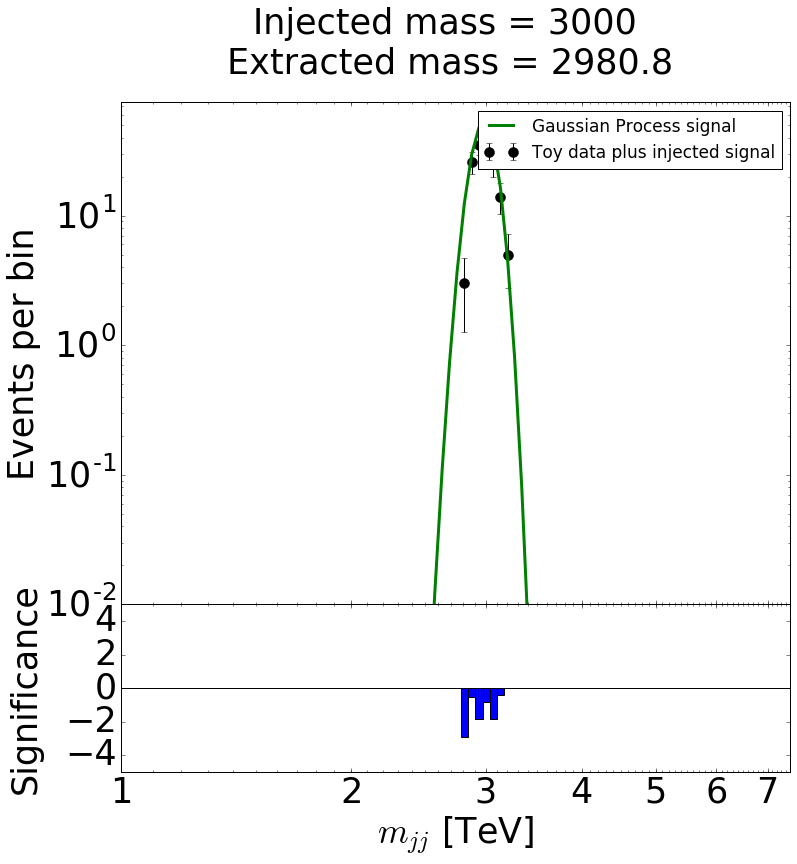

parameters (60, 3500, 250)
(2.1089657225181546, 1000.0000652936085, 124.04630926554275)
(3659.7978680878164, 1510.492763577076, 100.00017698830952)
(3235.186998975936, 1779.3262815520347, 100.00000098059614)
(3235.9186100745083, 1779.3418617782672, 100.0000002582009)
(1009.4215353549995, 3525.109208523091, 110.80701519422465)
(640.5766494666289, 3526.7083519352022, 121.00377568672096)
(639.6356142859842, 3526.701082769983, 120.99986175468642)
(639.9126687538354, 3526.6918353037245, 120.99380143022688)
A, mass, tau 639.912668754 3526.6918353 120.99380143
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 67.0920139352
chi2 bkg+signal nan


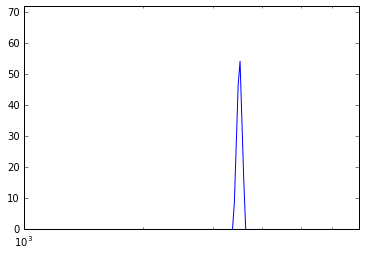

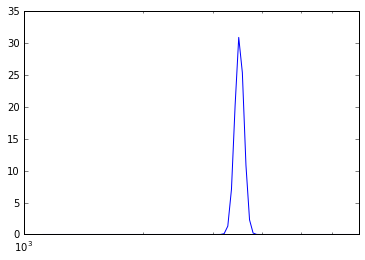

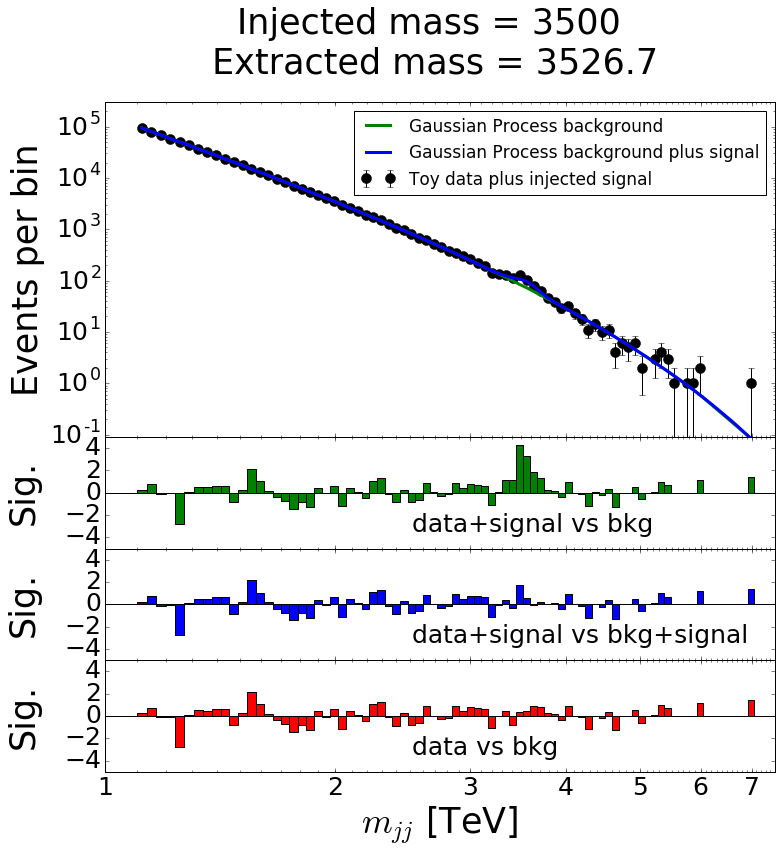

chi2 14.2903049873


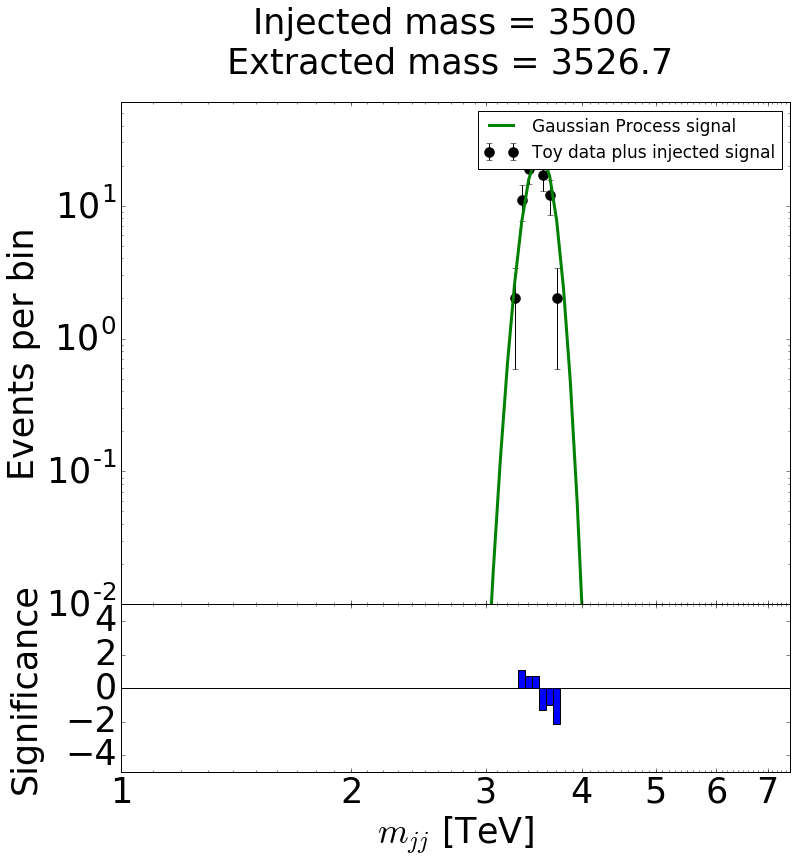

parameters (55, 4000, 250)
(3235.20018591938, 1779.3346387922725, 100.00003440776058)
(499.1485789410892, 3977.0991393428912, 100.04009102842231)
(500.3947001759667, 3977.15752456916, 100.0007142269936)
A, mass, tau 500.394700176 3977.15752457 100.000714227
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.4904736332
chi2 bkg+signal nan


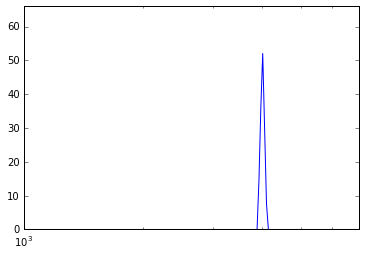

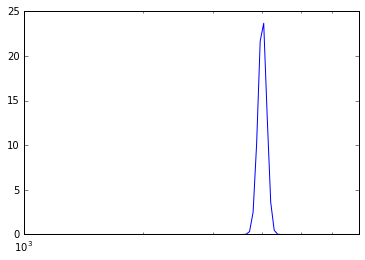

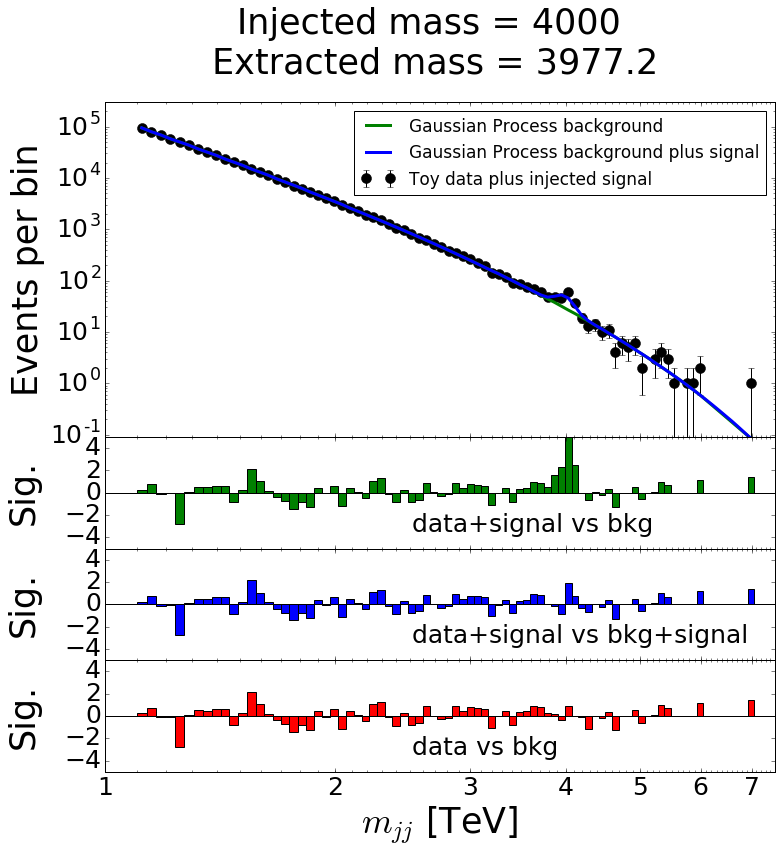

chi2 2.48225294903


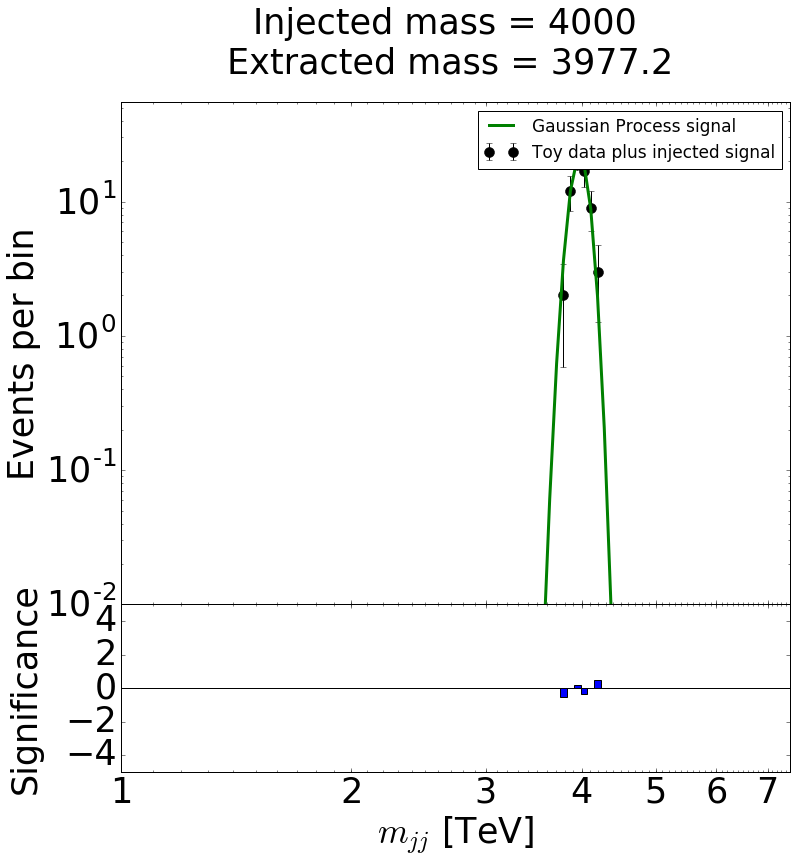

parameters (45, 4500, 250)
(2.1170599566210075, 1000.000000000296, 100.0000000000002)
(3702.267273569484, 1510.215377569959, 100.00001102894922)
(3245.2405620245245, 1778.8963889862375, 100.00028791332798)
(3226.7681108267175, 1779.4165093859544, 100.0001120060175)
(3229.970840150688, 1779.4172221644285, 100.000004055724)
(3235.4976511410514, 1779.3702453957485, 100.00000468753174)
(3236.254626238768, 1779.3338579400652, 100.00000011241987)
A, mass, tau 3236.25462624 1779.33385794 100.000000112
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 110.630416625
chi2 bkg+signal nan


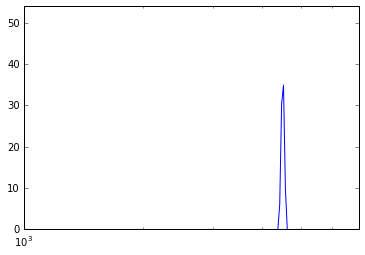

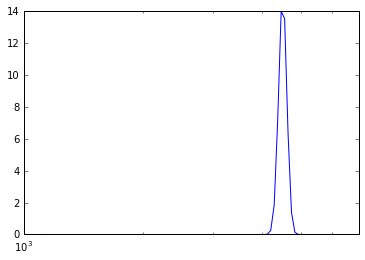

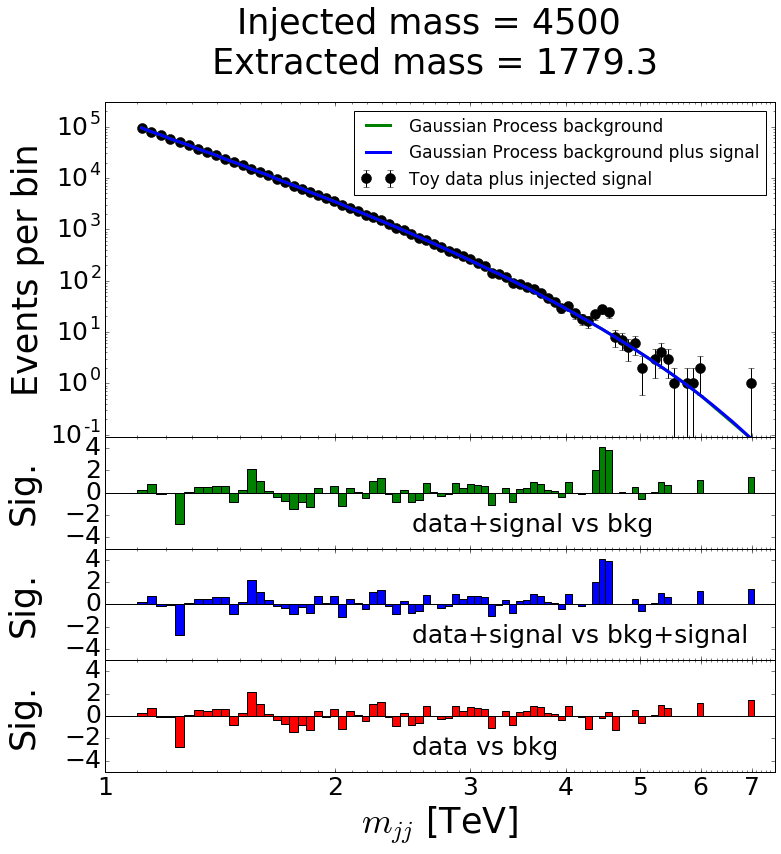

chi2 nan


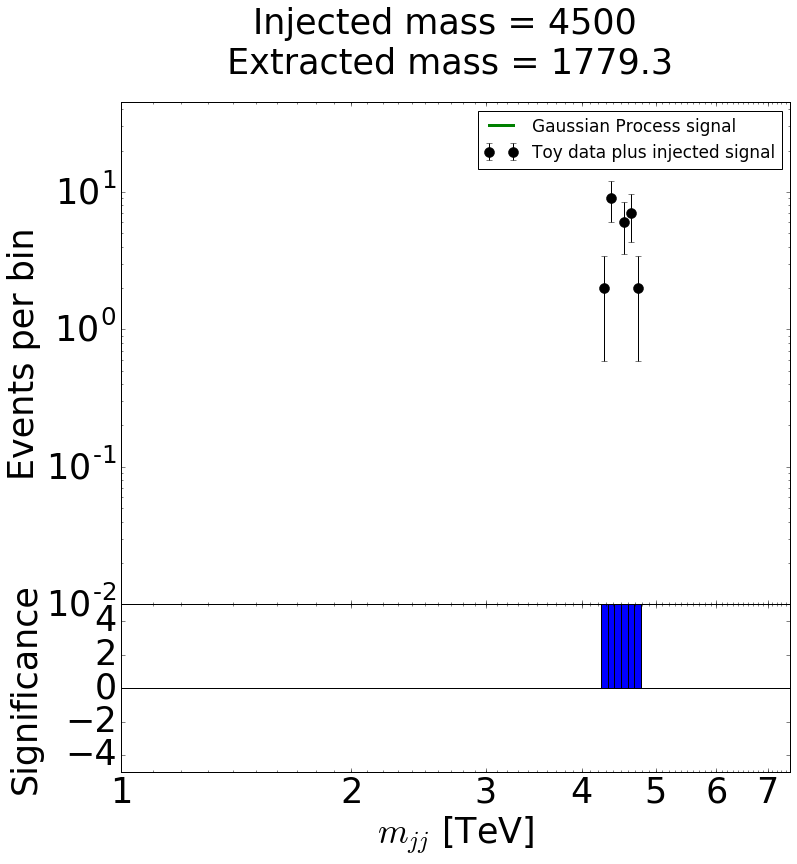

parameters (40, 5000, 250)
(1.0000000013766628, 2237.1122246098535, 100.00000029319129)
(79.54000333112477, 2974.443390913958, 100.00001299577792)
(3672.303324540766, 1510.4089530501938, 100.00000093674129)
(3233.1125916524725, 1779.2954692285778, 100.00000000297256)
(3234.594737290072, 1779.3354447850108, 100.00000092581224)
(3235.3609391064747, 1779.3514614379658, 100.00000001434269)
A, mass, tau 3235.36093911 1779.35146144 100.000000014


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 127.939761559
chi2 bkg+signal nan


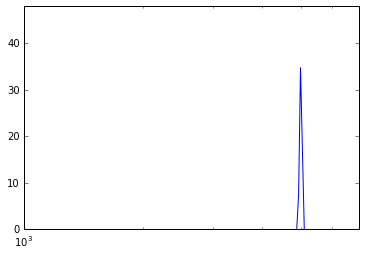

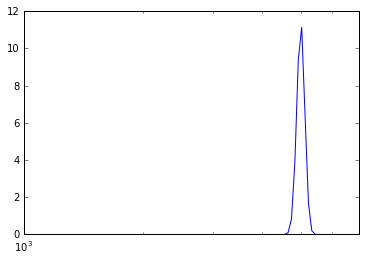

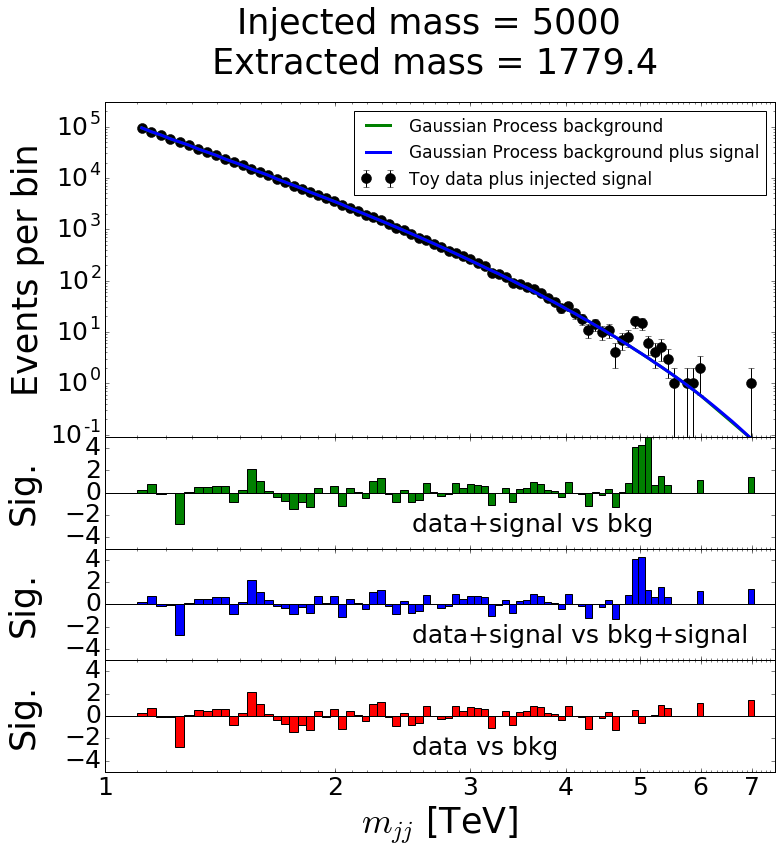

chi2 nan


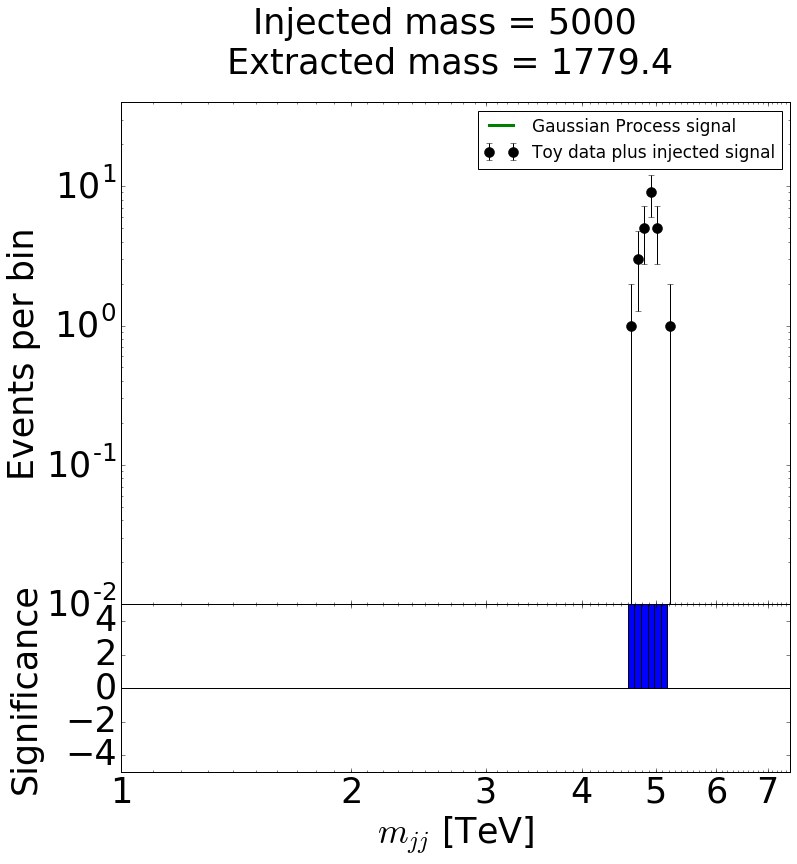

parameters (25, 5500, 250)
(3661.3269993899985, 1510.4094541181507, 100.0000003032613)
(3208.8086869141757, 1779.1819129321736, 100.00049973380658)
(3229.974458684568, 1779.3290870982232, 100.00000000671203)
(3232.6842256100867, 1779.334686206395, 100.00000896970829)
(3233.459447658026, 1779.345823924731, 100.00000478751667)
(3234.2393190950243, 1779.3287783623591, 100.00000053518802)
A, mass, tau 3234.2393191 1779.32877836 100.000000535
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 95.0634164008
chi2 bkg+signal nan


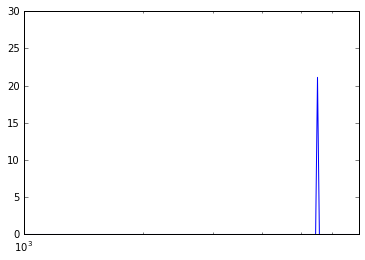

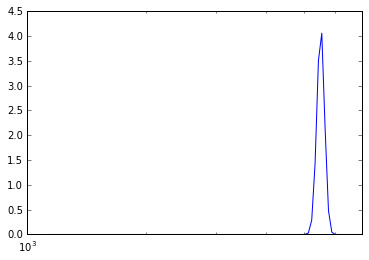

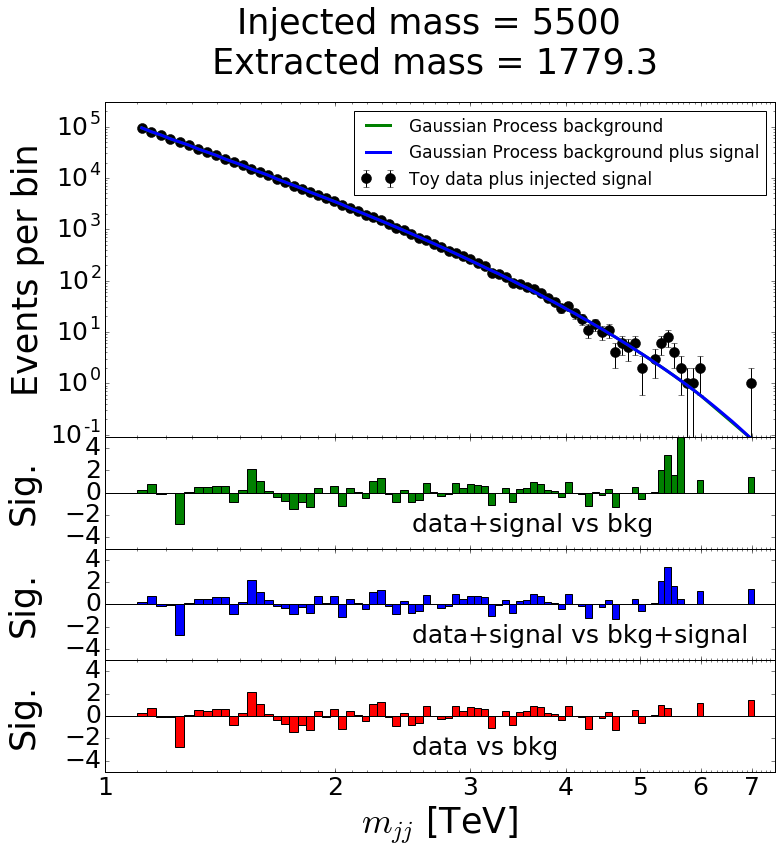

chi2 nan


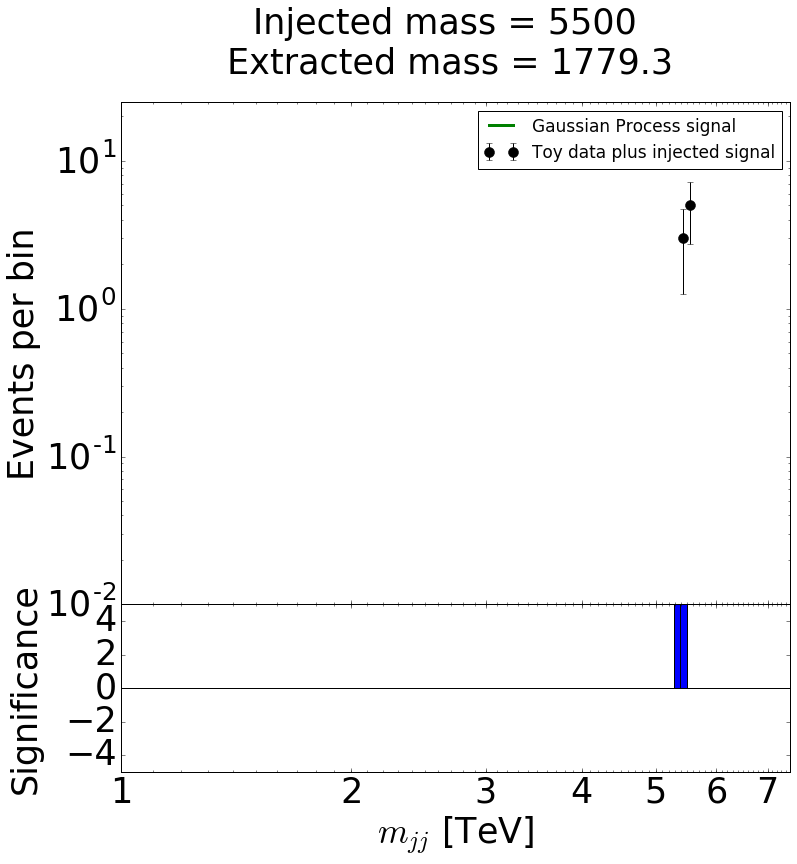

parameters (15, 6000, 250)
(1.9255458545917046, 1000.0000000003005, 100.00000000000017)
(1.0000011090406489, 1000.0000000000506, 104.40316443906174)
(80.31146062693755, 2974.7498703380948, 100.00000034035408)
(3231.9447005789975, 1779.2975844300154, 100.0000004052929)
(3233.3915532945107, 1779.3617778337957, 100.00000129484259)
A, mass, tau 3233.39155329 1779.36177783 100.000001295
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 100.118400128
chi2 bkg+signal nan


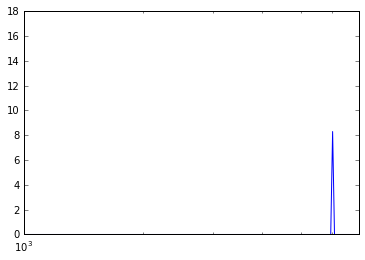

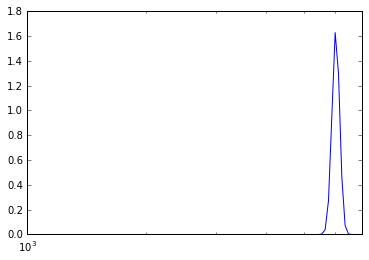

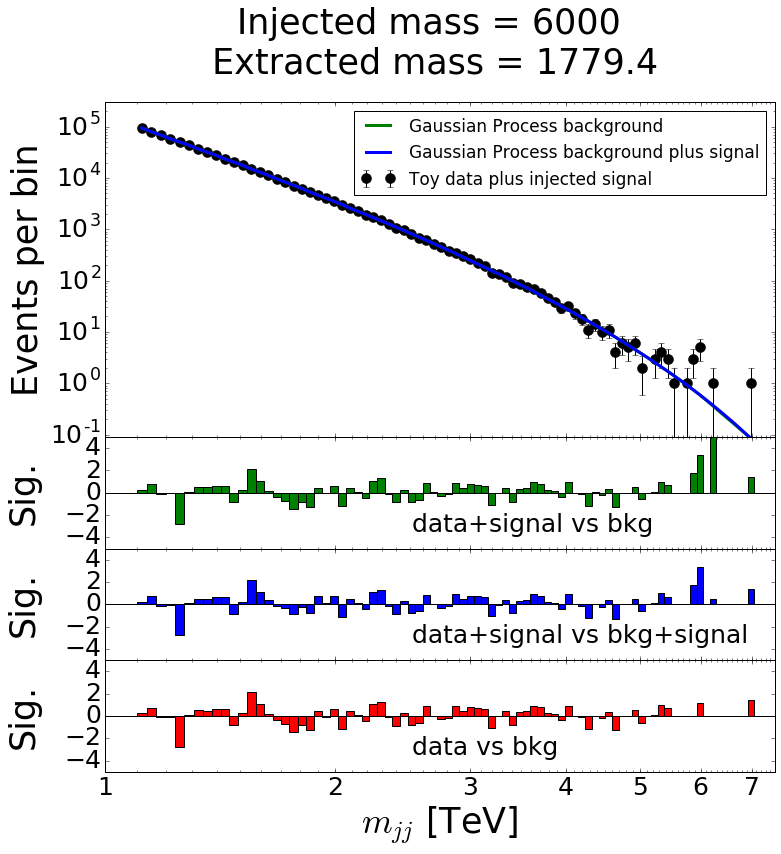

chi2 nan


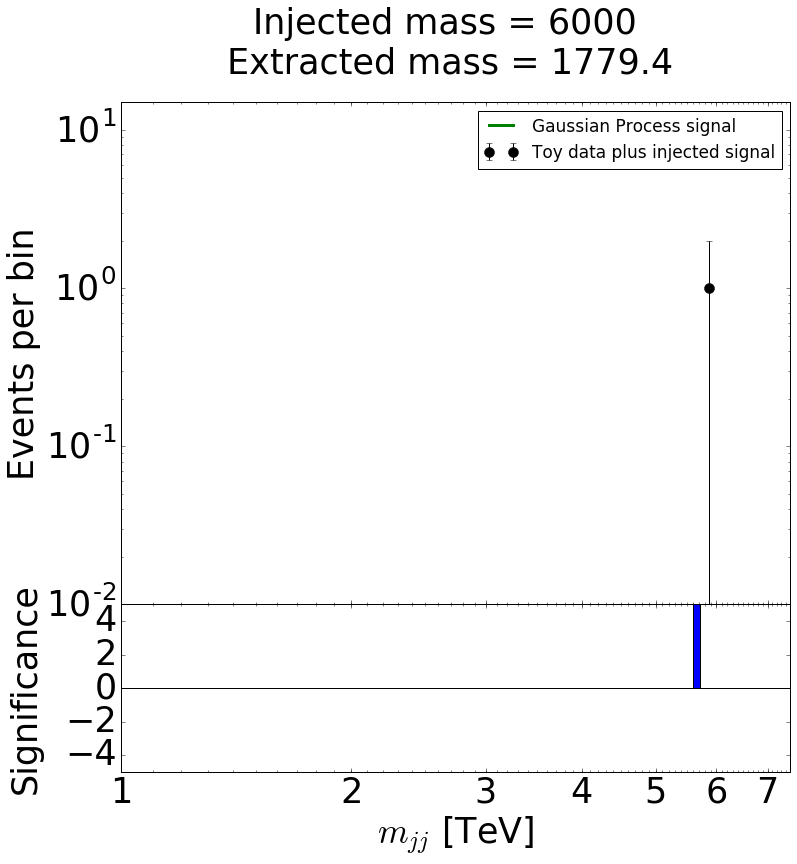

In [37]:
aa={}
mm={}
ww={}
standardParamSets = [(200,2000,300), (100 ,2500, 250), (75, 3000, 250), (60, 3500, 250), (55, 4000, 250), 
                     (45, 4500, 250), (40, 5000, 250), (25,5500, 250), (15, 6000,250)]


for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        

### square signals

parameters (100, 2000, 300)
(13592.735174048255, 2085.1417710802452, 165.500900124866)
(13608.5986909673, 2085.187247431997, 165.47379186490463)
(13599.383488112991, 2085.14954469809, 165.48748720749597)
(13650.707628911816, 2085.0607339664866, 165.55087842102412)
(13647.509455803589, 2085.1040337580507, 165.5189936614365)
(13622.214012939434, 2085.1195553439775, 165.4930719563263)
(13622.481734171692, 2085.109585510516, 165.51140456135965)
A, mass, tau 13622.4817342 2085.10958551 165.511404561


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.1230888974
chi2 bkg+signal nan


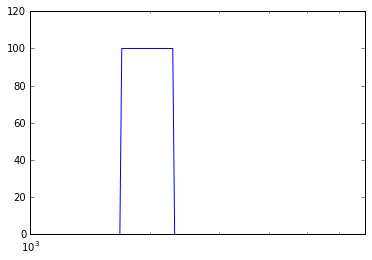

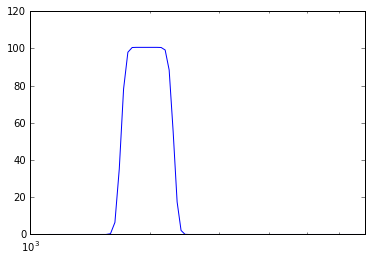

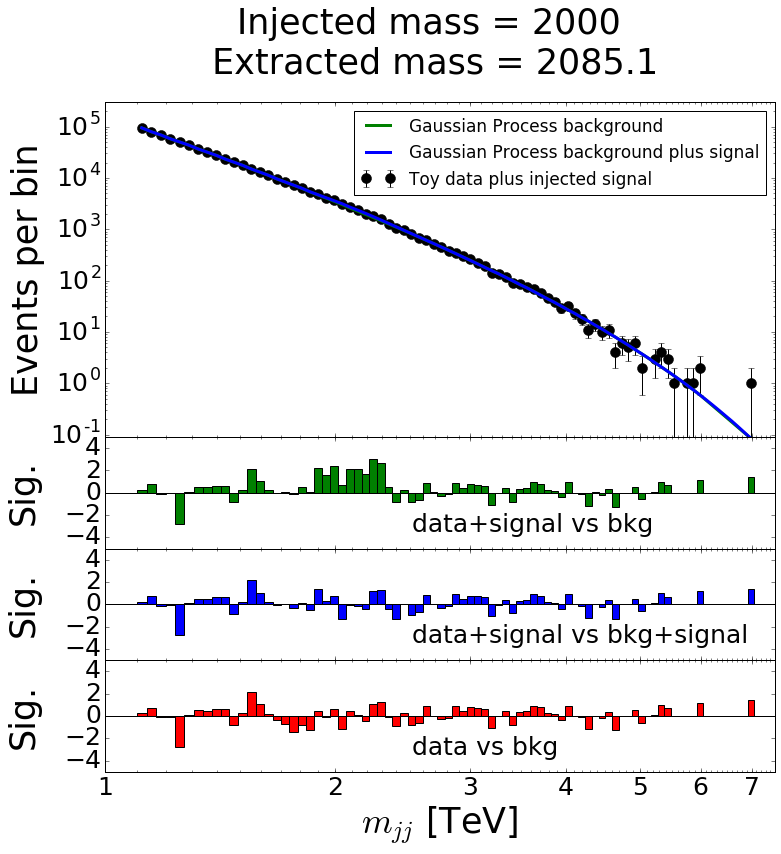

chi2 1455.39696509


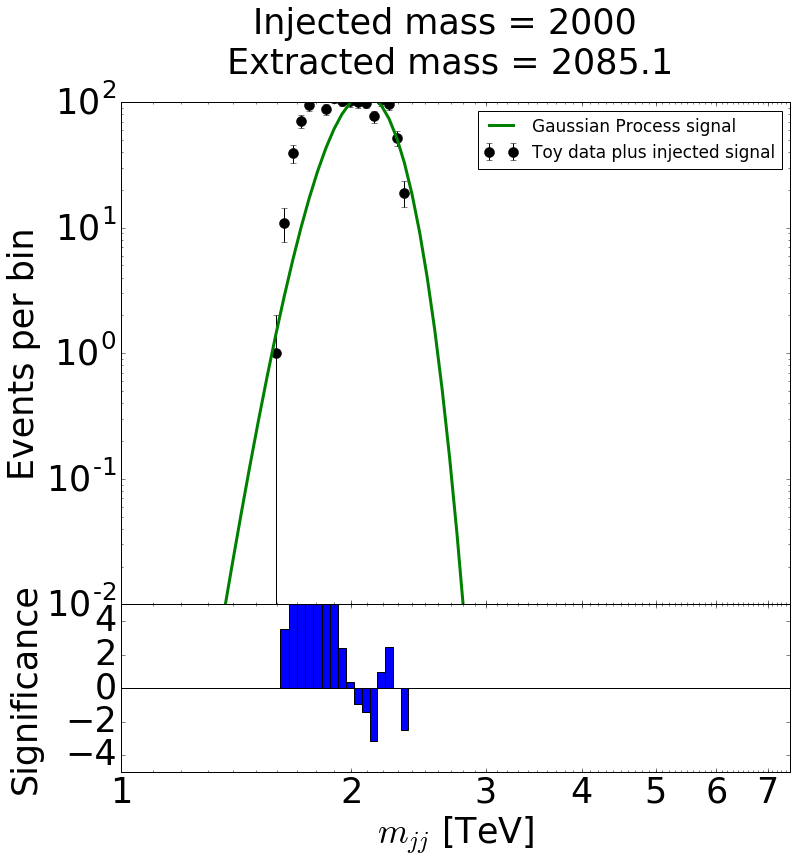

parameters (50, 2500, 250)
(3253.05258948714, 1779.6447161789365, 100.0)
(2206.0147183601375, 2475.3239263031737, 248.32804388742775)
(2206.451505427783, 2475.2559086526676, 248.36112641356485)
(2207.1194676320047, 2475.291698458431, 248.39259227013451)
(2207.1676473459916, 2475.287159984444, 248.38875769133432)
A, mass, tau 2207.16764735 2475.28715998 248.388757691
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 66.4125153744
chi2 bkg+signal nan


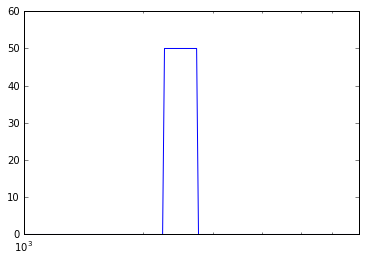

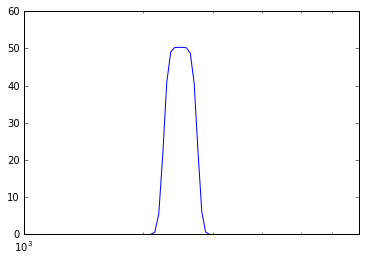

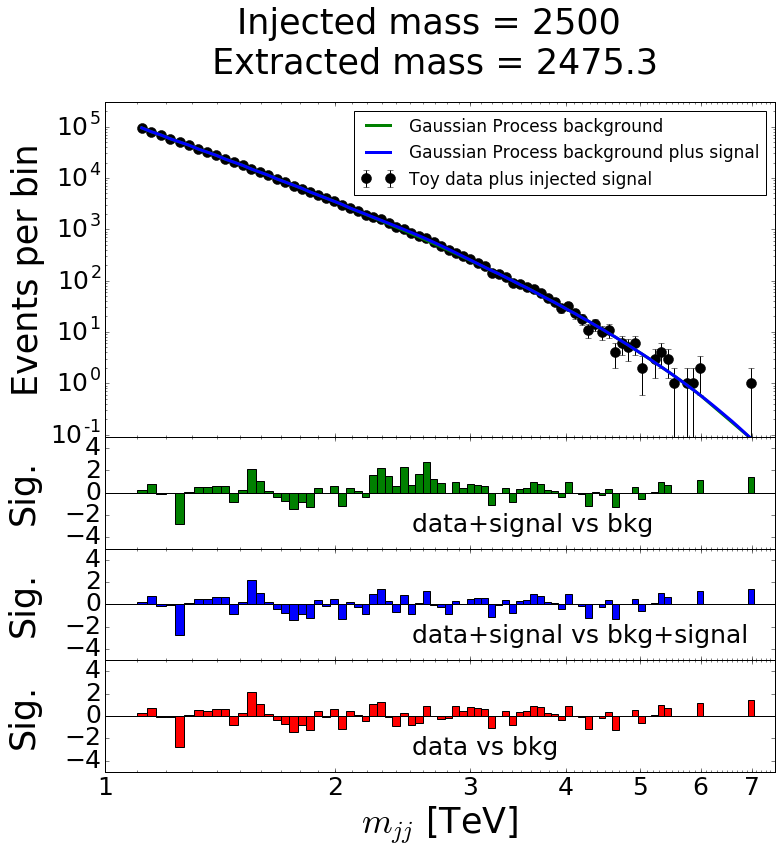

chi2 134.856127428


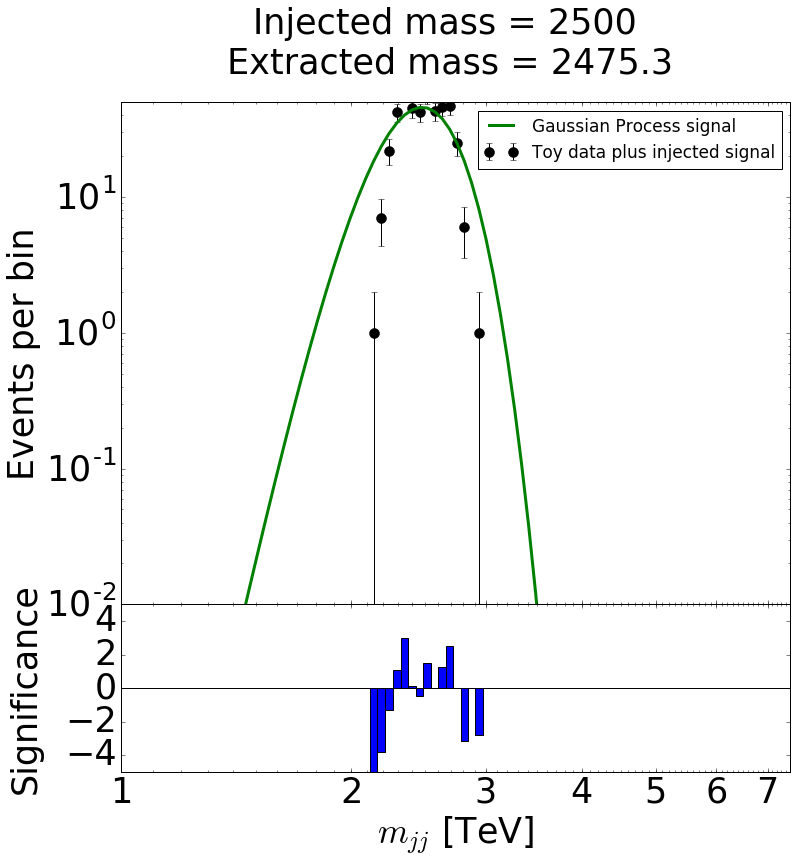

parameters (30, 3000, 250)
(2129.623672403438, 2965.4562931739556, 142.56733915681457)
(2131.5842738750507, 2965.446392956294, 142.5636961946148)
(2130.833393955228, 2965.4474721085835, 142.56178901335912)
A, mass, tau 2130.83339396 2965.44747211 142.561789013
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 63.402999238
chi2 bkg+signal nan


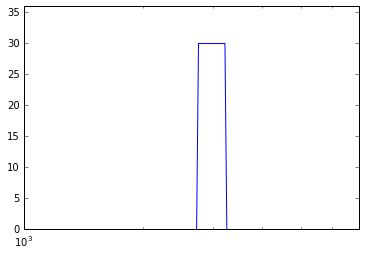

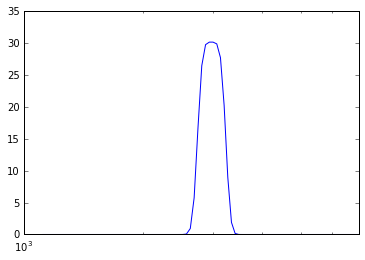

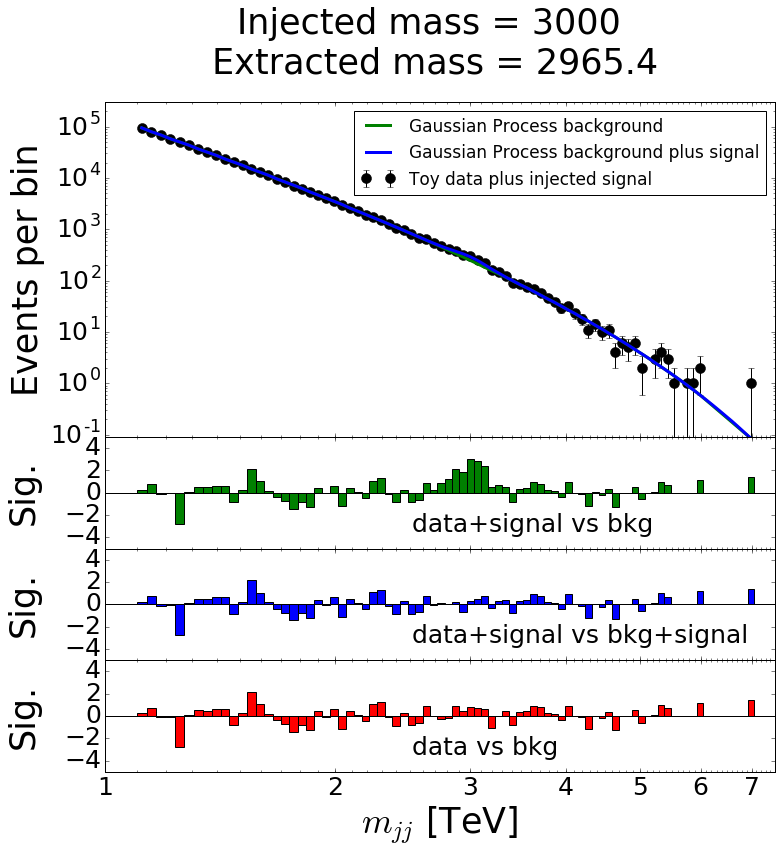

chi2 21.6307866509


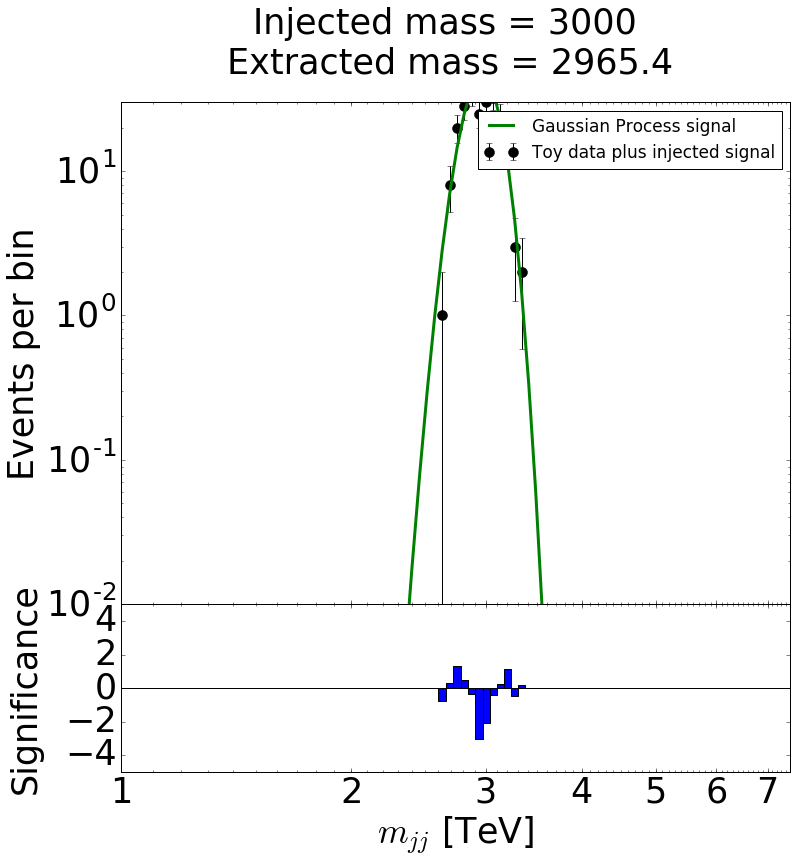

parameters (20, 3500, 250)
(2.0908260282209232, 1006.0926944825703, 100.00188754041777)
(3657.1540393097353, 1510.5157722066058, 100.00236285654293)
(3230.426445345118, 1779.2605946278627, 100.00000000090607)
(722.6906418531719, 3537.9124072902055, 171.092490472772)
(730.7253369360329, 3538.070042982845, 171.2699417665795)
(724.2586109410216, 3537.9149913248457, 171.3727153971942)
(726.9631267903864, 3537.9077468495784, 171.32356473627453)
(727.5176140952714, 3537.902523378231, 171.32062218757866)
A, mass, tau 727.517614095 3537.90252338 171.320622188
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.0907200675
chi2 bkg+signal nan


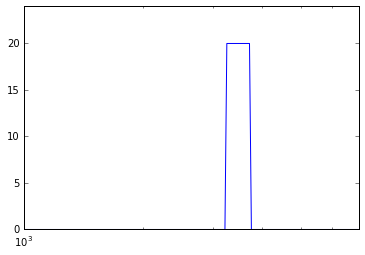

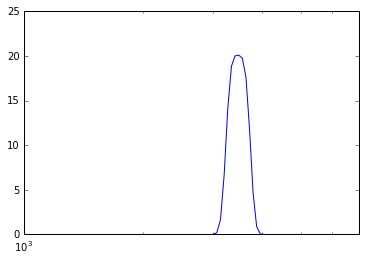

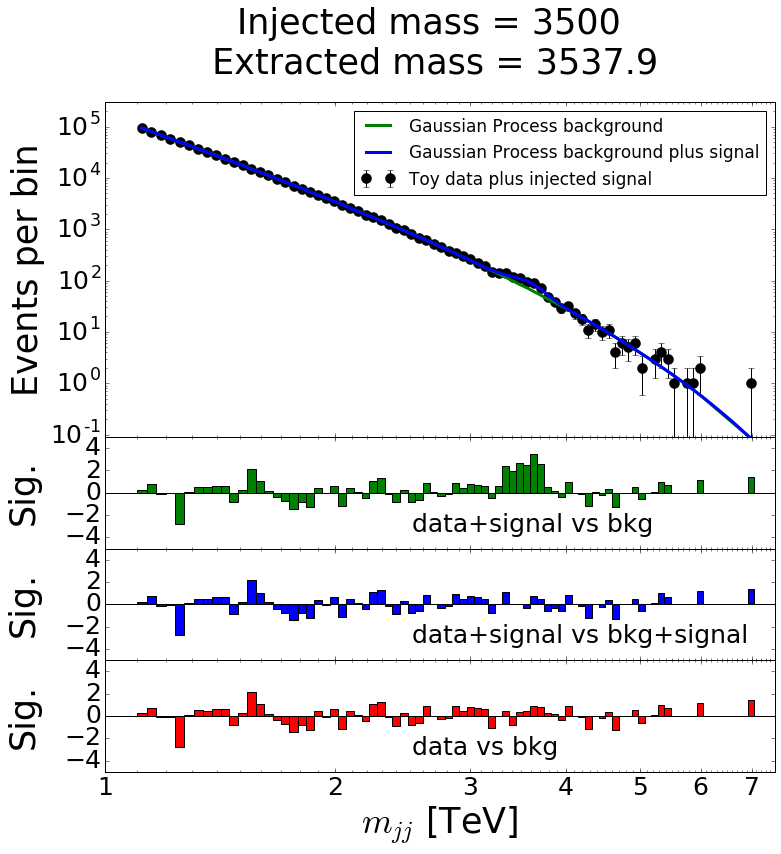

chi2 21.1242232929


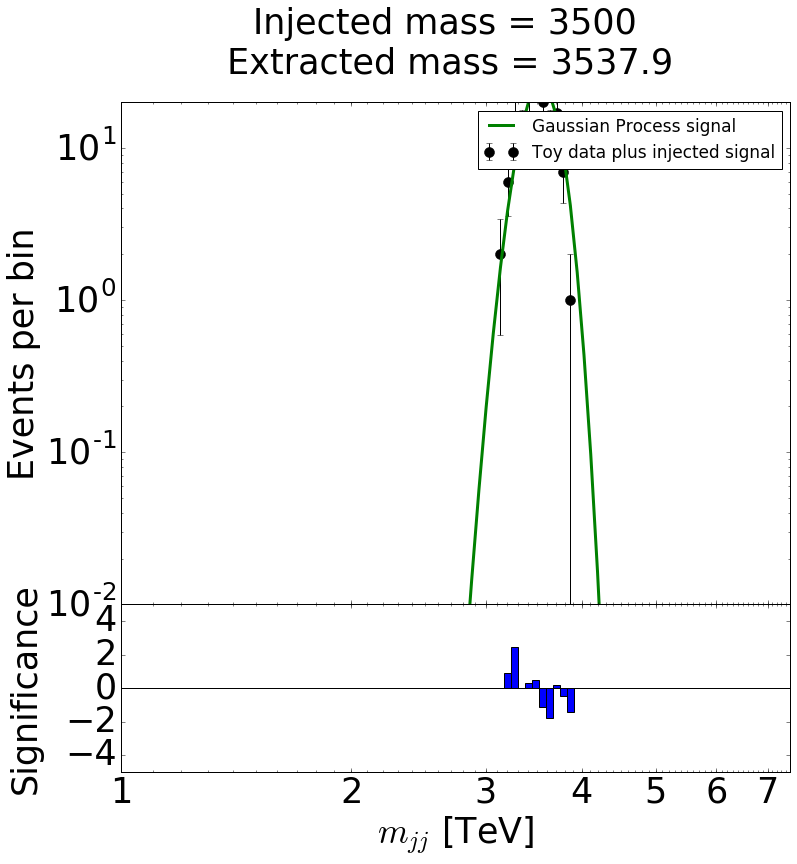

parameters (15, 4000, 250)
(1.0009777971795555, 2469.3014305750858, 100.00008119972752)
(1.0224885949181786, 2136.9227240476193, 100.25030227741392)
(3224.65585254452, 1779.4576989786467, 100.00013126565483)
(3236.0015950387756, 1779.4017471244829, 100.00000635512644)
(339.9746851256718, 3970.492670294744, 199.880535369788)
(340.1111836747556, 3970.5333107862666, 199.8371570020048)
(340.10522249179064, 3970.5205780748183, 199.85654681916384)
A, mass, tau 340.105222492 3970.52057807 199.856546819
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.8396348121
chi2 bkg+signal nan


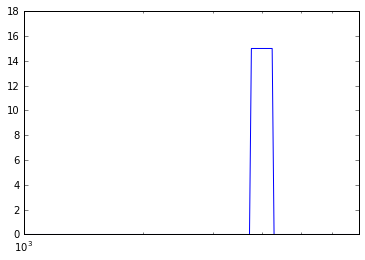

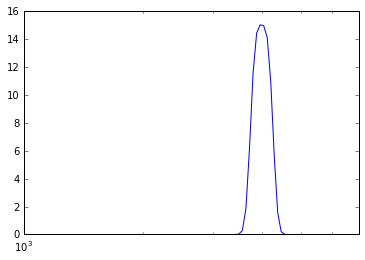

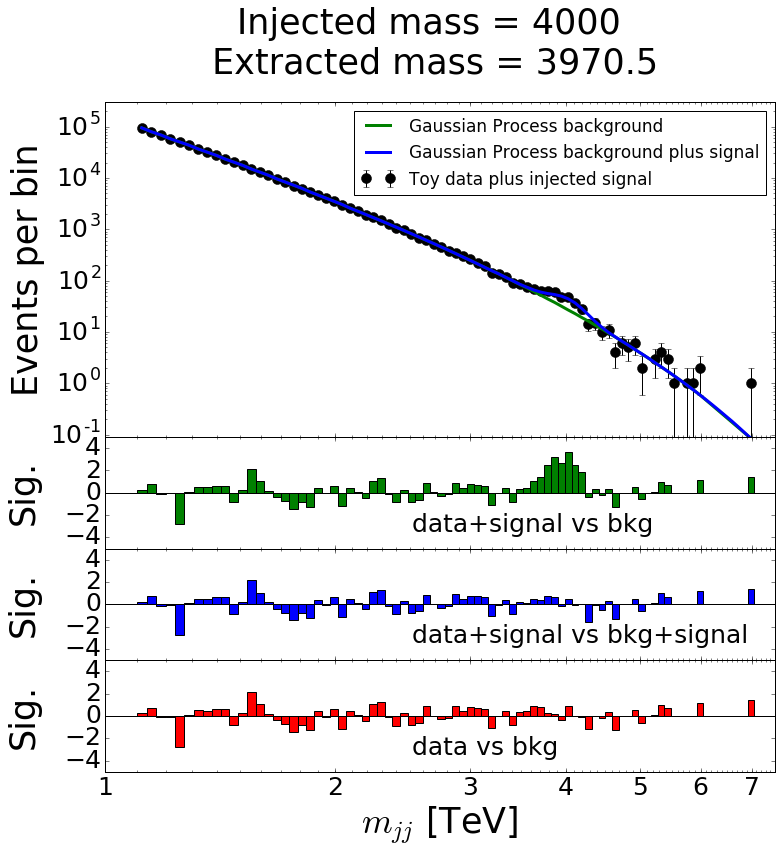

chi2 15.3932685854


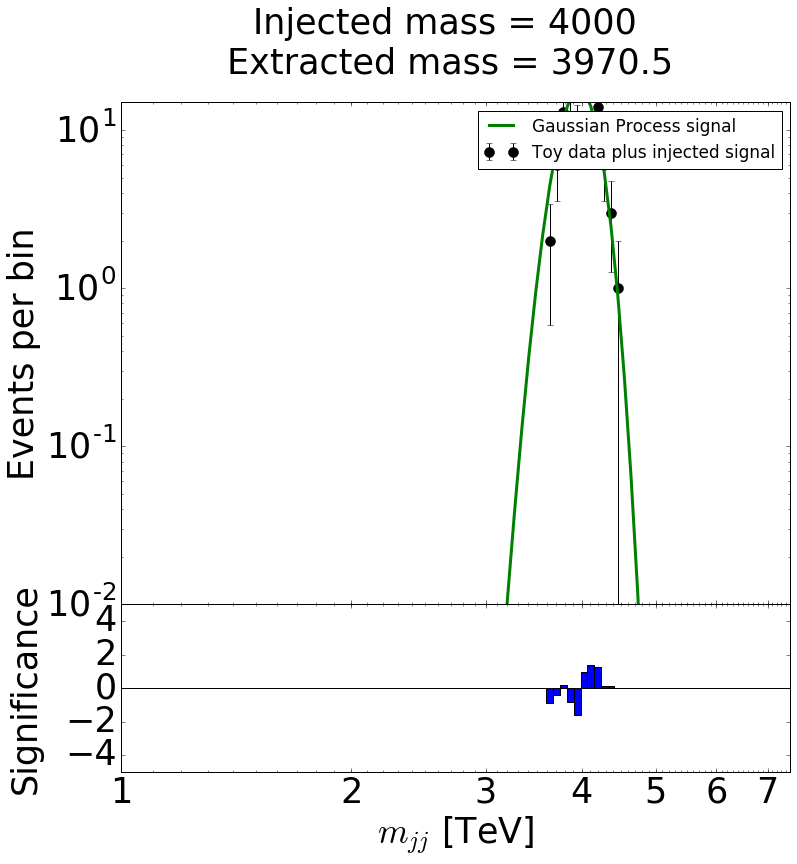

parameters (10, 4500, 250)
(3673.28095999771, 1510.0674972743368, 100.00000331916668)
(3231.6665698214993, 1779.5933902288716, 100.00000034891443)
(3239.566844673644, 1779.2893869250825, 100.00000016374209)
(3234.7377704650967, 1779.3077516433273, 100.00000057285435)
(197.31235487231456, 4492.881710792242, 100.00007337209904)
A, mass, tau 197.312354872 4492.88171079 100.000073372
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.8686012386
chi2 bkg+signal nan


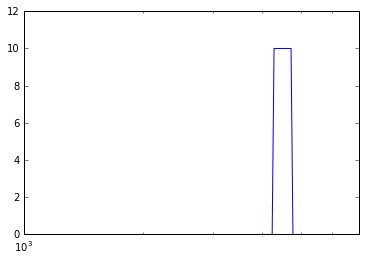

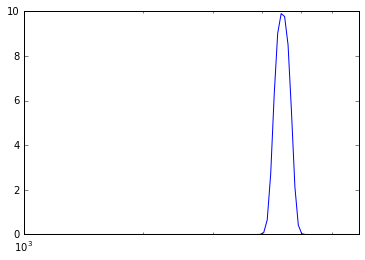

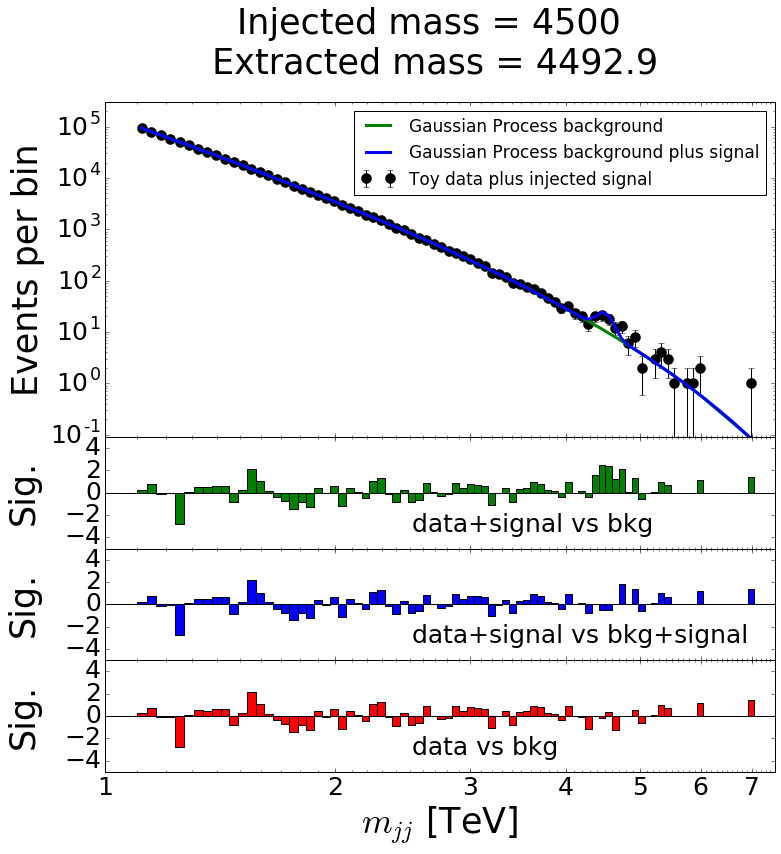

chi2 9477.64435213


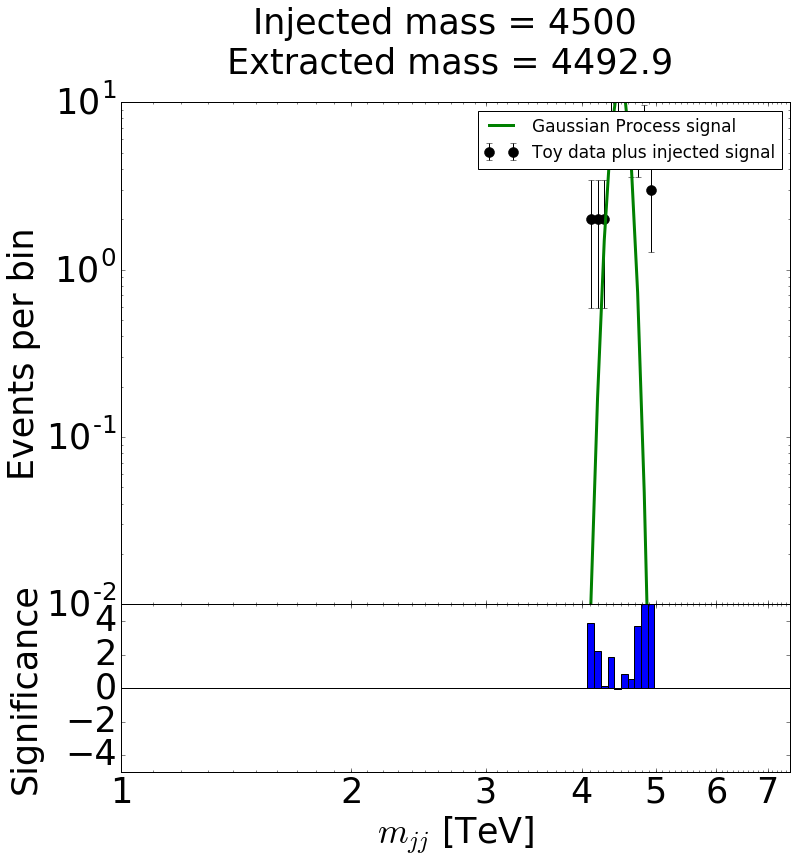

parameters (9, 5000, 250)
(1.6824001033687652, 1000.0000000001432, 100.51034025002437)
(1.0034499008158497, 1000.0000000003001, 100.00000000000023)
(3234.3768332221657, 1779.3332869728995, 100.00000381781811)
A, mass, tau 3234.37683322 1779.33328697 100.000003818


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 118.542060835
chi2 bkg+signal nan


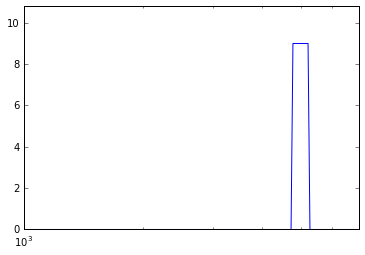

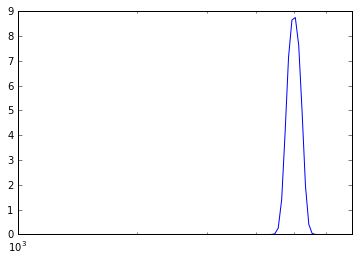

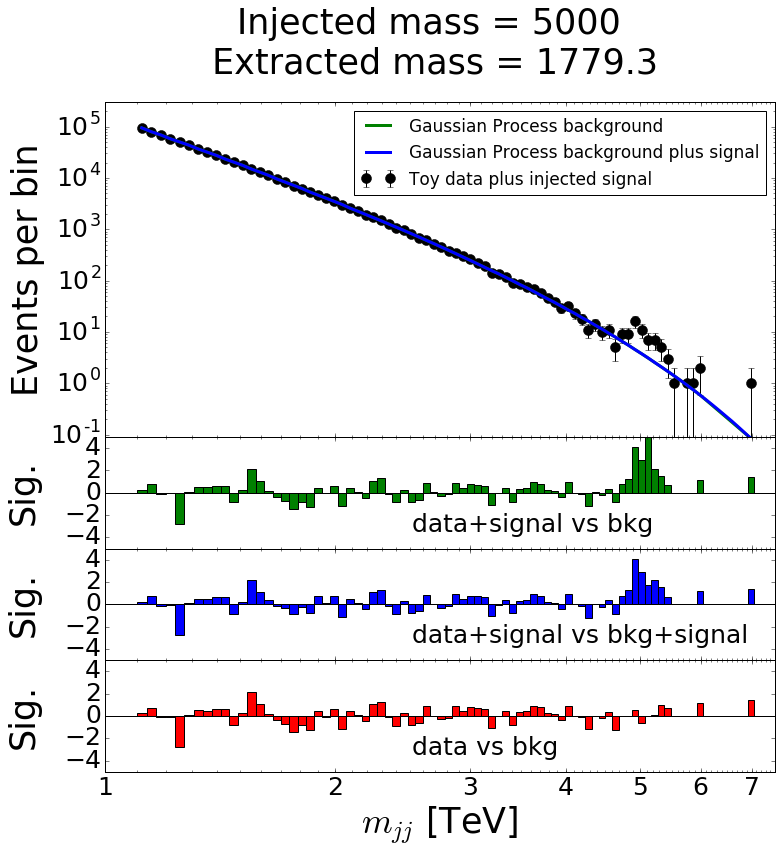

chi2 nan


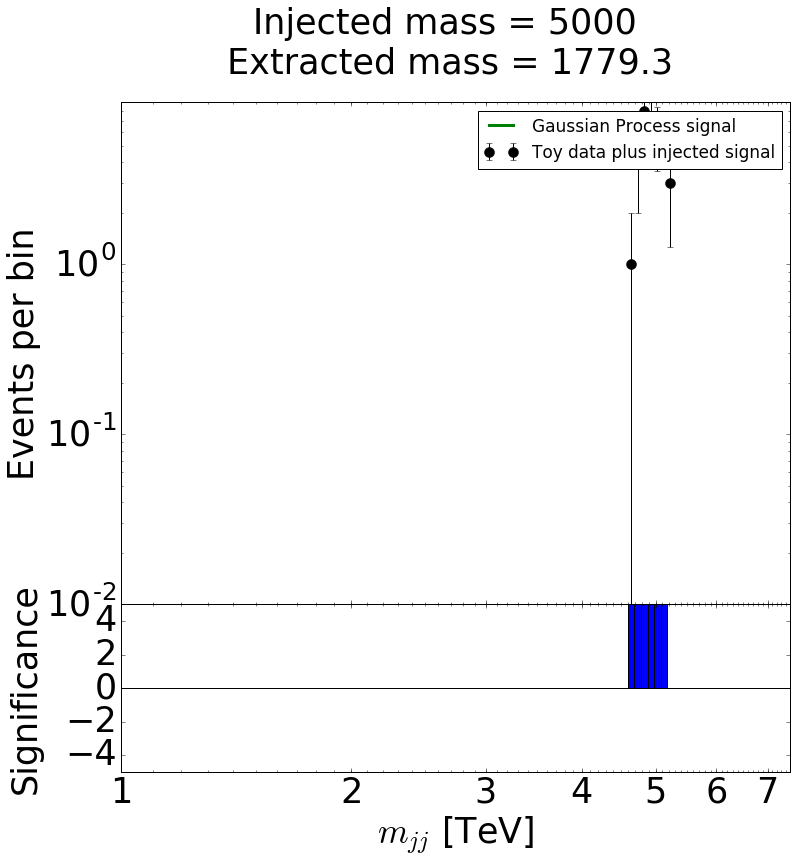

parameters (5, 5500, 250)
(82.08095420084233, 2974.348128585638, 100.00000313153348)
(3230.0897968488275, 1779.3303311226282, 100.00004275650396)
(3232.1776359706323, 1779.313469417124, 100.00000627129306)
(3238.6513748016814, 1779.3121857358071, 100.00000057009606)
(13.28286682008448, 5451.875061650942, 194.76322868542113)
A, mass, tau 13.2828668201 5451.87506165 194.763228685
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.8169759779
chi2 bkg+signal nan


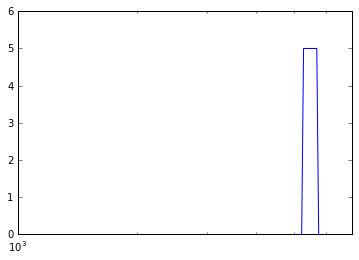

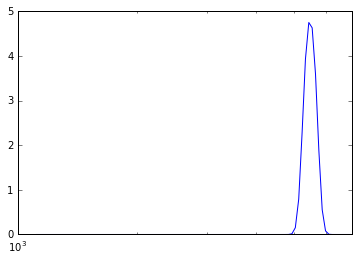

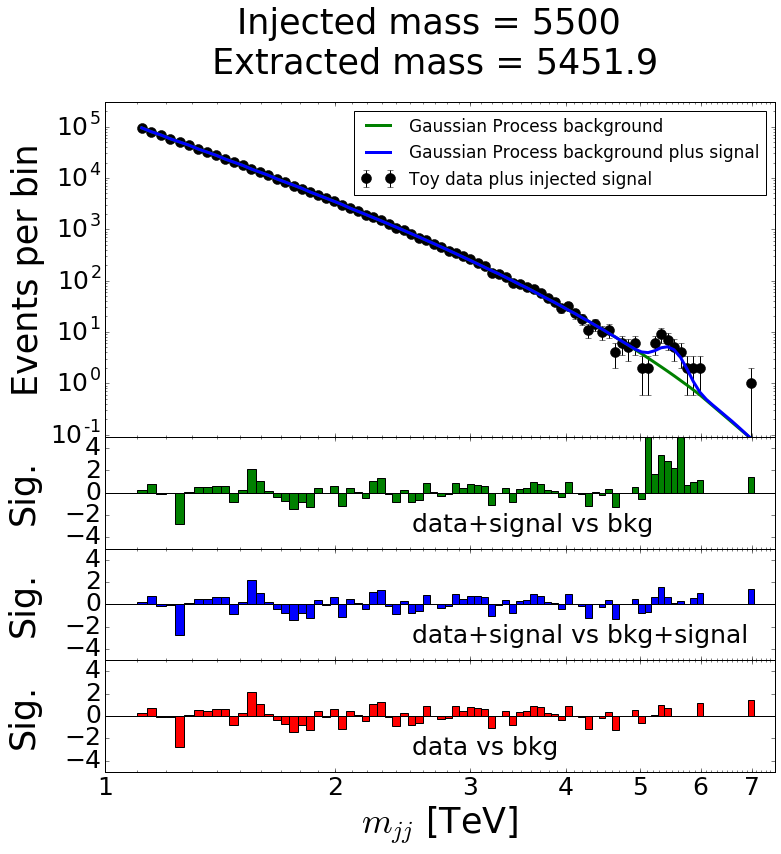

chi2 9.94500678249


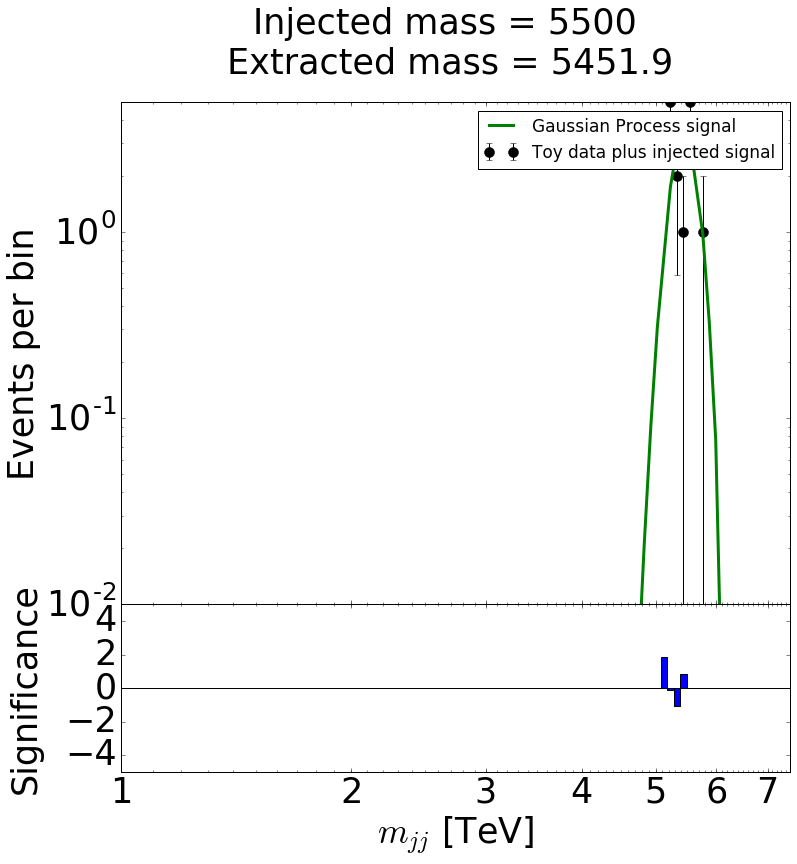

parameters (4, 6000, 250)
(1.0054450084610396, 1012.4849349865979, 100.07044979742076)
(1.0042583480117957, 1010.8216312650047, 100.0673791182487)
(1.0670344543277357, 1000.0000000003005, 100.0000000000002)
(3705.918404495905, 1511.0570102560694, 100.00001324154752)
(3209.339032230074, 1779.798572983527, 100.00000872911674)
(3232.756210498977, 1779.309914698525, 100.00000183691968)
(3233.6070622008633, 1779.334500890032, 100.00000581097888)
(170.01891477656167, 6317.277221489909, 286.168249216844)
A, mass, tau 170.018914777 6317.27722149 286.168249217
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 92.0431480937
chi2 bkg+signal nan


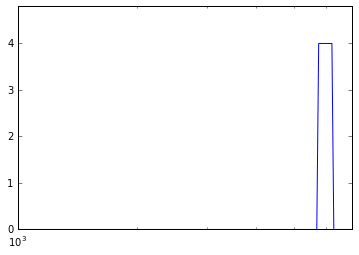

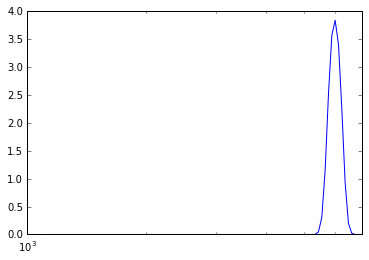

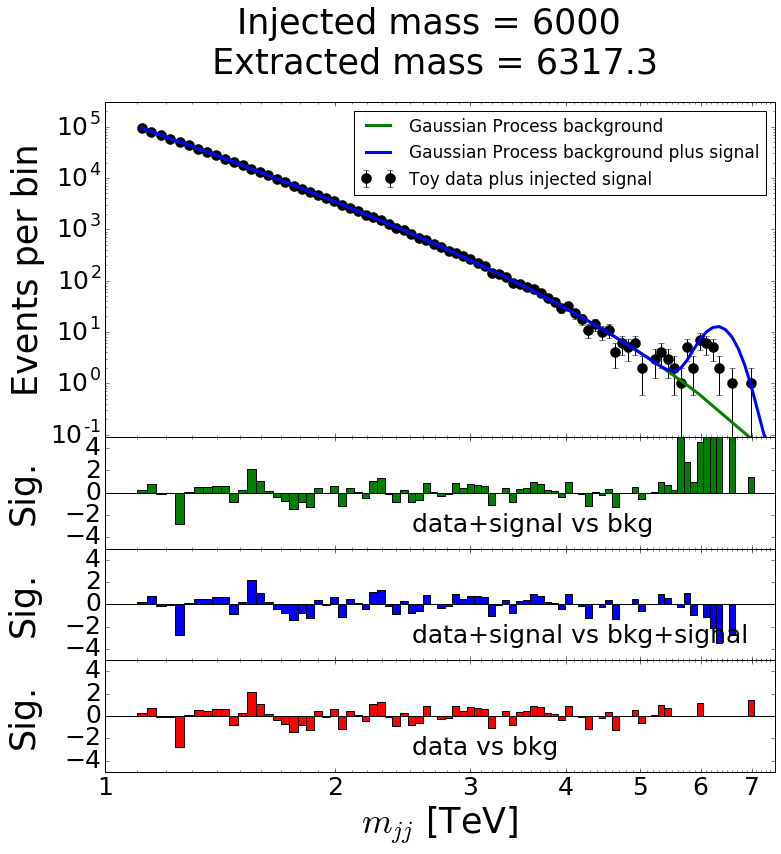

chi2 2.0305907277


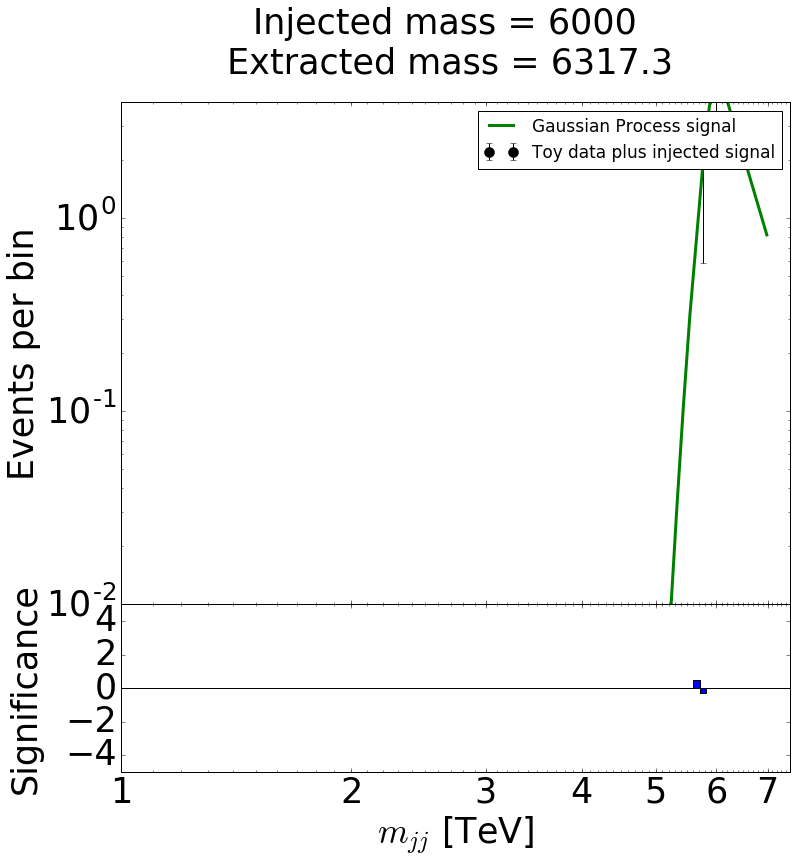

In [38]:
aa={}
mm={}
ww={}
standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]


for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        